In [1]:
# **Trying out a new way of loading time series data**


In [2]:
# The score might fluctuate from 0.483 to 0.487 due to some randomness 

In [1]:
import numpy as np
import pandas as pd
import os
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from scipy.stats import kurtosis
import numpy as np
import polars as pl
import pandas as pd
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

from sklearn.base import clone
from copy import deepcopy
import optuna
from scipy.optimize import minimize
import os
import matplotlib.pyplot as plt
import seaborn as sns

import re
from colorama import Fore, Style

from tqdm import tqdm
from IPython.display import clear_output
from concurrent.futures import ThreadPoolExecutor

import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

import lightgbm as lgb
from catboost import CatBoostRegressor, CatBoostClassifier
from xgboost import XGBRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.model_selection import *
from sklearn.metrics import *

SEED = 42
n_splits = 5

import numpy as np
import pandas as pd
import os
import re
from sklearn.base import clone
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import StratifiedKFold
from scipy.optimize import minimize
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

from colorama import Fore, Style
from IPython.display import clear_output
import warnings
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import VotingRegressor
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None


def process_file(filename, dirname):
    df = pd.read_parquet(os.path.join(dirname, filename, 'part-0.parquet'))
    df.drop('step', axis=1, inplace=True)

    # Convert 'time_of_day' to datetime
    df['time_of_day'] = pd.to_datetime(df['time_of_day'])
    df.set_index('time_of_day', inplace=True)

    # Daily aggregation
    daily_features = df.resample('D').agg({
        'X': ['mean', 'std', 'max', 'min', 'median', 'skew', lambda x: kurtosis(x, nan_policy='omit')],
        'Y': ['mean', 'std', 'max', 'min', 'median', 'skew', lambda x: kurtosis(x, nan_policy='omit')],
        'Z': ['mean', 'std', 'max', 'min', 'median', 'skew', lambda x: kurtosis(x, nan_policy='omit')],
        'enmo': ['mean', 'std', 'max', 'min', 'median', 'skew', lambda x: kurtosis(x, nan_policy='omit')],
        'light': ['mean', 'std'],
        'battery_voltage': ['mean', 'std'],
        'non-wear_flag': 'sum'
    })

    # Flatten the MultiIndex columns
    daily_features.columns = ['_'.join(col).strip() for col in daily_features.columns.values]
    
    # Add additional features
    daily_features['activity_count'] = (df['enmo'] > 0.1).resample('D').sum()  # Adjust threshold as needed
    daily_features['days_active'] = (df['non-wear_flag'] == 0).resample('D').sum()  # Count active days
    
    # Rate of change features
    daily_features['enmo_change'] = daily_features['enmo_mean'].diff()
    
    # Rolling statistics
    rolling_windows = [5, 10, 15]  # Days
    for window in rolling_windows:
        daily_features[f'enmo_rolling_mean_{window}'] = daily_features['enmo_mean'].rolling(window=window).mean()
        daily_features[f'enmo_rolling_std_{window}'] = daily_features['enmo_std'].rolling(window=window).std()

    # Frequency domain features using FFT
    for axis in ['X', 'Y', 'Z', 'enmo']:
        freq_features = np.fft.fft(df[axis])
        daily_features[f'{axis}_dominant_freq'] = np.abs(freq_features).argmax()

    # Reset index to retain 'id'
    daily_features.reset_index(inplace=True)
    
    # Extract child ID from filename
    child_id = filename.split('=')[1]
    daily_features['id'] = child_id

    return daily_features



def load_time_series(dirname) -> pd.DataFrame:
    ids = os.listdir(dirname)
    
    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(lambda fname: process_file(fname, dirname), ids), total=len(ids)))
    
    # Concatenate all results into a single DataFrame
    features_df = pd.concat(results, ignore_index=True)

    return features_df

# Build the autoencoder model
def build_autoencoder(input_dim, encoding_dim):
    input_layer = Input(shape=(input_dim,))
    
    # Encoder: compressing the input
    encoded = Dense(encoding_dim, activation='relu')(input_layer)
    
    # Decoder: reconstructing the input
    decoded = Dense(input_dim, activation='sigmoid')(encoded)
    
    # Autoencoder model
    autoencoder = Model(inputs=input_layer, outputs=decoded)
    
    # Encoder model (for getting the compressed representation)
    encoder = Model(inputs=input_layer, outputs=encoded)
    
    autoencoder.compile(optimizer=Adam(), loss='mse')
    
    return autoencoder, encoder

# Function to perform dimensionality reduction using an autoencoder
def perform_autoencoder(df, encoding_dim=50, epochs=50, batch_size=32):
    """
    Perform dimensionality reduction using an Autoencoder.

    Parameters:
    df (pd.DataFrame): The input DataFrame with numerical features.
    encoding_dim (int): The dimension of the encoded space.
    epochs (int): Number of epochs to train the autoencoder.
    batch_size (int): Size of the batches for training.

    Returns:
    pd.DataFrame: DataFrame containing the reduced-dimensional representation (encoding).
    """
    
    # Step 1: Standardize the data
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df)
    
    # Step 2: Build the autoencoder
    input_dim = df_scaled.shape[1]
    autoencoder, encoder = build_autoencoder(input_dim, encoding_dim)
    
    # Step 3: Train the autoencoder
    autoencoder.fit(df_scaled, df_scaled, epochs=epochs, batch_size=batch_size, shuffle=True, verbose=1)
    
    # Step 4: Get the encoded (reduced) representation
    encoded_data = encoder.predict(df_scaled)
    
    # Step 5: Create a DataFrame for the encoded features
    df_encoded = pd.DataFrame(encoded_data, columns=[f'Enc_{i+1}' for i in range(encoded_data.shape[1])])
    
    return df_encoded

# Load the data
train = pd.read_csv('/Users/ad53533/Desktop/Applied ML/Project/train.csv')
test = pd.read_csv('/Users/ad53533/Desktop/Applied ML/Project/test.csv')
sample = pd.read_csv('/Users/ad53533/Desktop/Applied ML/Project/sample_submission.csv')

train_ts = load_time_series("/Users/ad53533/Desktop/Applied ML/Project/series_train.parquet")
test_ts = load_time_series("/Users/ad53533/Desktop/Applied ML/Project/series_test.parquet")

100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


In [2]:
# Columns to drop
columns_to_drop = [
    'enmo_change',
    'enmo_rolling_mean_5',
    'enmo_rolling_std_5',
    'enmo_rolling_mean_10',
    'enmo_rolling_std_10',
    'enmo_rolling_mean_15',
    'enmo_rolling_std_15'
]

# Drop the columns
train_ts.drop(columns=columns_to_drop, inplace=True)

# Drop the columns
test_ts.drop(columns=columns_to_drop, inplace=True)

In [3]:
train_ts

,time_of_day,X_mean,X_std,X_max,X_min,X_median,X_skew,X_<lambda_0>,Y_mean,Y_std,Y_max,Y_min,Y_median,Y_skew,Y_<lambda_0>,Z_mean,Z_std,Z_max,Z_min,Z_median,Z_skew,Z_<lambda_0>,enmo_mean,enmo_std,enmo_max,enmo_min,enmo_median,enmo_skew,enmo_<lambda_0>,light_mean,light_std,battery_voltage_mean,battery_voltage_std,non-wear_flag_sum,activity_count,days_active,X_dominant_freq,Y_dominant_freq,Z_dominant_freq,enmo_dominant_freq,id
0,1970-01-01,-0.478973,0.429476,1.159667,-3.298790,-0.578881,1.160975,1.103127,-0.037643,0.518888,2.525316,-3.262288,-0.006695,-0.216507,-0.321342,-0.215956,0.422696,1.802745,-1.134395,-0.211011,0.362773,-0.246828,0.061542,0.129369,4.568309,0.0,0.027122,9.354017,142.868651,41.468445,180.046051,3876.515625,121.027328,0.0,45199,269335,0,0,0,0,0d01bbf2
1,1970-01-01,0.047866,0.523529,1.859814,-1.777734,0.009822,-0.123027,-0.819444,0.003234,0.441043,1.518311,-2.433394,0.008072,0.020400,-0.215713,-0.249981,0.646242,1.510279,-1.005808,-0.383322,0.624025,-0.808320,0.023465,0.052369,3.006919,0.0,0.006272,10.122232,247.097163,68.818008,278.520935,3841.463623,165.178589,89280.0,25247,319114,3,1,0,0,cefdb7fe
2,1970-01-01,-0.088861,0.300414,1.017271,-2.163437,0.005507,-0.223285,1.579890,0.045154,0.371415,1.381445,-3.142938,0.002966,1.017172,1.471402,-0.212270,0.840652,1.041023,-1.001401,-0.636735,0.404848,-1.622866,0.004798,0.027894,4.491224,0.0,0.000079,84.609940,10615.052950,9.674906,47.171303,3838.082031,145.005997,234833.5,1291,141608,0,2,1,0,58391429
3,1970-01-01,-0.080044,0.601258,1.148359,-1.962057,-0.190000,0.244350,-1.261574,0.058017,0.595227,3.186745,-2.844661,0.093646,-0.160917,-1.168621,-0.269036,0.375193,2.724948,-1.021510,-0.278828,0.520652,0.359949,0.045412,0.095615,4.054967,0.0,0.022030,11.050422,239.551423,132.968597,434.872345,3874.709717,133.966049,0.0,36990,311959,3,3,0,0,2ca2206f
4,1970-01-01,-0.067303,0.282437,2.427422,-3.150714,-0.049600,0.473135,3.860532,0.187596,0.528473,2.343212,-4.179972,-0.005727,0.131484,-0.494820,-0.381376,0.669284,2.094606,-1.019038,-0.594736,0.680334,-0.772329,0.018893,0.075737,5.087605,0.0,0.009630,17.778378,542.471560,10.622702,39.840015,3829.777344,147.438263,248040.0,13012,122497,0,1,0,0,19455336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
991,1970-01-01,0.034996,0.278136,1.962949,-2.375542,-0.010207,1.225661,5.813969,0.382648,0.594951,1.764815,-2.212997,0.456311,-0.623768,-0.552848,-0.365085,0.521853,1.581940,-1.008145,-0.148559,0.148526,-1.015109,0.008409,0.074923,3.816627,0.0,0.000729,22.536623,656.872871,8.340188,46.997593,3854.254883,167.211823,323825.5,6415,88053,424128,0,0,0,43a7386d
992,1970-01-01,-0.227848,0.505671,1.163996,-2.023180,-0.311040,0.466316,-0.707714,-0.117374,0.523569,2.271134,-2.103810,-0.107125,0.170669,-0.817215,-0.109314,0.546679,1.489056,-1.051996,-0.139521,0.322509,-0.727153,0.070964,0.129672,2.631471,0.0,0.028815,5.241410,45.608473,23.489414,47.289898,4024.496094,94.727821,0.0,13590,72533,0,0,0,0,2840643b
993,1970-01-01,0.470508,0.451261,2.261910,-0.989845,0.604042,-1.241216,0.931505,0.069204,0.434032,1.023213,-5.156441,0.086445,-0.377222,0.246141,-0.119591,0.556132,2.497662,-1.008375,-0.154146,0.264887,-1.008317,0.044411,0.117474,4.914551,0.0,0.009824,9.065800,142.754232,35.851643,154.012482,3852.268799,163.722580,1440.0,47160,400166,0,0,0,0,1b329556
994,1970-01-01,0.001327,0.509230,2.621233,-2.147763,-0.036661,0.092827,-0.496257,-0.233908,0.547428,2.709097,-3.231679,-0.098634,0.082353,-0.822928,-0.117364,0.579877,2.616484,-1.083508,-0.101701,0.286324,-0.676041,0.038436,0.146497,5.241471,0.0,0.002339,12.444243,226.417954,28.920023,151.741760,3845.556641,164.792923,123557.5,33341,274116,7,0,0,0,62b873a2


In [4]:
# Drop 'id' column for training
df_train = train_ts.drop('id', axis=1)
df_test = test_ts.drop('id', axis=1)

In [5]:
df_train.dtypes

time_of_day             datetime64[ns]
X_mean                         float32
X_std                          float32
X_max                          float32
X_min                          float32
X_median                       float32
X_skew                         float32
X_<lambda_0>                   float64
Y_mean                         float32
Y_std                          float32
Y_max                          float32
Y_min                          float32
Y_median                       float32
Y_skew                         float32
Y_<lambda_0>                   float64
Z_mean                         float32
Z_std                          float32
Z_max                          float32
Z_min                          float32
Z_median                       float32
Z_skew                         float32
Z_<lambda_0>                   float64
enmo_mean                      float32
enmo_std                       float32
enmo_max                       float32
enmo_min                 

In [6]:
df_train

,time_of_day,X_mean,X_std,X_max,X_min,X_median,X_skew,X_<lambda_0>,Y_mean,Y_std,Y_max,Y_min,Y_median,Y_skew,Y_<lambda_0>,Z_mean,Z_std,Z_max,Z_min,Z_median,Z_skew,Z_<lambda_0>,enmo_mean,enmo_std,enmo_max,enmo_min,enmo_median,enmo_skew,enmo_<lambda_0>,light_mean,light_std,battery_voltage_mean,battery_voltage_std,non-wear_flag_sum,activity_count,days_active,X_dominant_freq,Y_dominant_freq,Z_dominant_freq,enmo_dominant_freq
0,1970-01-01,-0.478973,0.429476,1.159667,-3.298790,-0.578881,1.160975,1.103127,-0.037643,0.518888,2.525316,-3.262288,-0.006695,-0.216507,-0.321342,-0.215956,0.422696,1.802745,-1.134395,-0.211011,0.362773,-0.246828,0.061542,0.129369,4.568309,0.0,0.027122,9.354017,142.868651,41.468445,180.046051,3876.515625,121.027328,0.0,45199,269335,0,0,0,0
1,1970-01-01,0.047866,0.523529,1.859814,-1.777734,0.009822,-0.123027,-0.819444,0.003234,0.441043,1.518311,-2.433394,0.008072,0.020400,-0.215713,-0.249981,0.646242,1.510279,-1.005808,-0.383322,0.624025,-0.808320,0.023465,0.052369,3.006919,0.0,0.006272,10.122232,247.097163,68.818008,278.520935,3841.463623,165.178589,89280.0,25247,319114,3,1,0,0
2,1970-01-01,-0.088861,0.300414,1.017271,-2.163437,0.005507,-0.223285,1.579890,0.045154,0.371415,1.381445,-3.142938,0.002966,1.017172,1.471402,-0.212270,0.840652,1.041023,-1.001401,-0.636735,0.404848,-1.622866,0.004798,0.027894,4.491224,0.0,0.000079,84.609940,10615.052950,9.674906,47.171303,3838.082031,145.005997,234833.5,1291,141608,0,2,1,0
3,1970-01-01,-0.080044,0.601258,1.148359,-1.962057,-0.190000,0.244350,-1.261574,0.058017,0.595227,3.186745,-2.844661,0.093646,-0.160917,-1.168621,-0.269036,0.375193,2.724948,-1.021510,-0.278828,0.520652,0.359949,0.045412,0.095615,4.054967,0.0,0.022030,11.050422,239.551423,132.968597,434.872345,3874.709717,133.966049,0.0,36990,311959,3,3,0,0
4,1970-01-01,-0.067303,0.282437,2.427422,-3.150714,-0.049600,0.473135,3.860532,0.187596,0.528473,2.343212,-4.179972,-0.005727,0.131484,-0.494820,-0.381376,0.669284,2.094606,-1.019038,-0.594736,0.680334,-0.772329,0.018893,0.075737,5.087605,0.0,0.009630,17.778378,542.471560,10.622702,39.840015,3829.777344,147.438263,248040.0,13012,122497,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
991,1970-01-01,0.034996,0.278136,1.962949,-2.375542,-0.010207,1.225661,5.813969,0.382648,0.594951,1.764815,-2.212997,0.456311,-0.623768,-0.552848,-0.365085,0.521853,1.581940,-1.008145,-0.148559,0.148526,-1.015109,0.008409,0.074923,3.816627,0.0,0.000729,22.536623,656.872871,8.340188,46.997593,3854.254883,167.211823,323825.5,6415,88053,424128,0,0,0
992,1970-01-01,-0.227848,0.505671,1.163996,-2.023180,-0.311040,0.466316,-0.707714,-0.117374,0.523569,2.271134,-2.103810,-0.107125,0.170669,-0.817215,-0.109314,0.546679,1.489056,-1.051996,-0.139521,0.322509,-0.727153,0.070964,0.129672,2.631471,0.0,0.028815,5.241410,45.608473,23.489414,47.289898,4024.496094,94.727821,0.0,13590,72533,0,0,0,0
993,1970-01-01,0.470508,0.451261,2.261910,-0.989845,0.604042,-1.241216,0.931505,0.069204,0.434032,1.023213,-5.156441,0.086445,-0.377222,0.246141,-0.119591,0.556132,2.497662,-1.008375,-0.154146,0.264887,-1.008317,0.044411,0.117474,4.914551,0.0,0.009824,9.065800,142.754232,35.851643,154.012482,3852.268799,163.722580,1440.0,47160,400166,0,0,0,0
994,1970-01-01,0.001327,0.509230,2.621233,-2.147763,-0.036661,0.092827,-0.496257,-0.233908,0.547428,2.709097,-3.231679,-0.098634,0.082353,-0.822928,-0.117364,0.579877,2.616484,-1.083508,-0.101701,0.286324,-0.676041,0.038436,0.146497,5.241471,0.0,0.002339,12.444243,226.417954,28.920023,151.741760,3845.556641,164.792923,123557.5,33341,274116,7,0,0,0


In [7]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from keras.models import Model
from keras.layers import Input, Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

def build_autoencoder(input_dim, encoding_dim):
    input_layer = Input(shape=(input_dim,))
    
    # Encoder: compressing the input
    encoded = Dense(encoding_dim, activation='relu')(input_layer)
    
    # Decoder: reconstructing the input
    decoded = Dense(input_dim, activation='sigmoid')(encoded)
    
    # Autoencoder model
    autoencoder = Model(inputs=input_layer, outputs=decoded)
    
    # Encoder model (for getting the compressed representation)
    encoder = Model(inputs=input_layer, outputs=encoded)
    
    autoencoder.compile(optimizer=Adam(), loss='mse')
    
    return autoencoder, encoder

def perform_autoencoder(df, encoding_dim=50, epochs=200, batch_size=32):
    scaler = StandardScaler()
    
    # Exclude non-numeric columns
    df_numeric = df.select_dtypes(include=[np.number])
    
    # Check for and handle NaN values
    if df_numeric.isnull().values.any():
        df_numeric.fillna(df_numeric.mean(), inplace=True)

    if np.isinf(df_numeric).values.any():
        df_numeric.replace([np.inf, -np.inf], np.nan, inplace=True)
        df_numeric.fillna(df_numeric.mean(), inplace=True)

    df_scaled = scaler.fit_transform(df_numeric)

    # Check for NaN values after scaling
    if np.isnan(df_scaled).any() or np.isinf(df_scaled).any():
        print("NaN or infinite values detected in the scaled data!")
        return None  # or handle as needed

    input_dim = df_scaled.shape[1]
    autoencoder, encoder = build_autoencoder(input_dim, encoding_dim)
    
    # Use a smaller learning rate for stability
    autoencoder.compile(optimizer=Adam(learning_rate=0.0001), loss='mse')
    
    # Set up early stopping
    early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

    # Train the autoencoder with early stopping
    autoencoder.fit(df_scaled, df_scaled, 
                    epochs=epochs, 
                    batch_size=batch_size, 
                    shuffle=True, 
                    verbose=1, 
                    callbacks=[early_stopping])

    encoded_data = encoder.predict(df_scaled)
    
    df_encoded = pd.DataFrame(encoded_data, columns=[f'Enc_{i+1}' for i in range(encoded_data.shape[1])])
    
    return df_encoded


In [8]:
# # Perform autoencoder dimensionality reduction
# train_ts_encoded = perform_autoencoder(df_train, encoding_dim=60, epochs=100, batch_size=32)
# test_ts_encoded = perform_autoencoder(df_test, encoding_dim=60, epochs=100, batch_size=32)

train_ts_encoded = perform_autoencoder(df_train, encoding_dim=64, epochs=256, batch_size=32)
test_ts_encoded = perform_autoencoder(df_test, encoding_dim=64,epochs=256, batch_size=32)


Epoch 1/256
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 505us/step - loss: 1.2452
Epoch 2/256
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 369us/step - loss: 1.3124
Epoch 3/256
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 385us/step - loss: 1.2243
Epoch 4/256
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 310us/step - loss: 1.2696
Epoch 5/256
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step - loss: 1.0823
Epoch 6/256
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 318us/step - loss: 1.1761
Epoch 7/256
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step - loss: 1.1349
Epoch 8/256
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step - loss: 1.1224
Epoch 9/256
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 301us/step - loss: 1.0937
Epoch 10/256
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step - loss: 1.0843
Epoch 11/256
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step - loss: 1.1364
Epoch 12/256
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step - loss: 1.0802
Epoch 13/256
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 308us/step - loss: 1.0561
Epoch 14/256
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step - loss: 1.0454
Epoch 15/256
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [9]:
train_ts_encoded

,Enc_1,Enc_2,Enc_3,Enc_4,Enc_5,Enc_6,Enc_7,Enc_8,Enc_9,Enc_10,Enc_11,Enc_12,Enc_13,Enc_14,Enc_15,Enc_16,Enc_17,Enc_18,Enc_19,Enc_20,Enc_21,Enc_22,Enc_23,Enc_24,Enc_25,Enc_26,Enc_27,Enc_28,Enc_29,Enc_30,Enc_31,Enc_32,Enc_33,Enc_34,Enc_35,Enc_36,Enc_37,Enc_38,Enc_39,Enc_40,Enc_41,Enc_42,Enc_43,Enc_44,Enc_45,Enc_46,Enc_47,Enc_48,Enc_49,Enc_50,Enc_51,Enc_52,Enc_53,Enc_54,Enc_55,Enc_56,Enc_57,Enc_58,Enc_59,Enc_60,Enc_61,Enc_62,Enc_63,Enc_64
0,1.144983,0.000000,0.000000,0.000000,1.275270,0.000000,2.268480,0.353247,0.000000,0.154833,0.000000,1.458065,0.000000,0.000000,1.906131,2.185433,1.619872,1.178820,0.000000,0.906762,2.575856,0.000000,0.908757,0.689060,1.033448,0.000000,2.845150,0.000000,0.000000,0.000000,0.000000,3.368498,0.610702,2.573679,0.000000,0.000000,2.214271,0.428537,1.287644,3.058682,0.070774,0.000000,0.000000,0.000000,0.000000,1.619223,3.179074,0.604454,0.286560,1.421862,0.098923,1.476515,0.101590,0.000000,2.513826,0.000000,0.000000,2.192334,1.608207,0.095563,2.015658,2.260750,0.000000,1.248163
1,2.639385,2.038112,1.331718,0.525545,0.000000,0.202462,0.000000,0.000000,2.862018,0.490152,0.000000,1.226579,0.890373,0.377359,0.354527,0.469685,1.862419,1.422733,0.316557,0.000000,0.797553,0.120723,0.771232,1.384079,0.938959,0.435571,0.000000,1.704414,1.798645,1.246635,1.517307,0.000000,0.000000,0.223926,0.939245,0.461146,0.109100,0.000000,0.360696,0.446767,1.162992,0.705526,1.176078,0.000000,0.254198,0.236668,0.000000,0.200044,0.539820,1.574664,0.708304,0.164379,0.000000,3.151373,0.256758,0.000000,1.053874,0.839485,0.000000,0.735911,2.185395,0.335097,1.166198,0.000000
2,0.000000,4.038998,1.142757,0.000000,0.000000,4.143946,0.000000,6.767039,0.000000,3.761167,3.027341,0.000000,3.208272,4.748824,0.876724,0.000000,0.000000,0.000000,0.000000,0.000000,2.332362,4.138856,4.039042,5.130177,0.000000,1.294192,0.000000,0.000000,1.246776,0.000000,1.910493,0.047910,0.800096,0.000000,0.000000,1.832480,0.000000,3.591614,0.000000,0.000000,0.000000,0.030100,0.000000,3.057420,4.659322,3.155664,0.000000,1.189531,0.309525,0.000000,0.000000,1.728317,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.392980,3.114930,0.000000
3,3.767752,0.249002,0.000000,1.304782,0.000000,0.000000,0.000000,0.000000,0.904398,0.000000,0.053659,3.120163,0.000000,0.000000,0.536722,1.813304,2.871259,2.156491,0.000000,1.284699,0.958360,0.000000,0.000000,0.000000,1.900785,0.000000,2.985111,0.000000,0.000000,0.000000,0.000000,1.899420,0.000000,0.000000,1.456886,0.000000,1.549967,0.000000,1.345766,2.833555,1.478526,0.000000,0.000000,0.000000,0.095639,0.000000,1.888848,0.580040,0.000000,1.624612,0.000000,0.000000,0.000000,1.599764,2.039032,0.496524,0.000000,0.628231,2.794668,0.000000,2.368279,0.000000,0.000000,1.340685
4,0.000000,4.012470,1.325199,0.000000,0.000000,1.122400,0.000000,1.423463,0.302644,1.744553,3.092426,0.000000,0.436857,2.068069,0.000000,0.000000,0.000000,2.434187,0.000000,0.379874,1.264845,0.147553,2.108691,3.069685,0.000000,0.000000,1.533254,0.685044,1.140683,0.000000,0.000000,1.000322,1.528125,2.492701,0.000000,0.631876,0.000000,1.102049,0.687910,0.000000,0.000000,0.986116,0.000000,1.609164,2.447518,1.819831,0.000000,0.000000,0.000000,0.602949,0.000000,1.219380,0.308011,0.000000,0.000000,0.000000,0.689807,0.000000,0.000000,3.013400,0.000000,3.899216,2.721020,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
991,0.000000,3.399496,0.675502,0.000000,0.000000,0.209328,0.835667,2.148900,0.143372,0.000000,4.981218,0.000000,1.776718,1.295610,0.000000,0.000000,0.541926,3.240388,0.000000,0.000000,0.000000,2.192739,5.804691,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.826492,0.951400,0.000000,1.635233,0.000000,4.539220,0.000000,0.632085,0.000000,0.000000,0.000000,0.000000,2.604801,1.912581,3.946751,0

In [10]:
test_ts_encoded

,Enc_1,Enc_2,Enc_3,Enc_4,Enc_5,Enc_6,Enc_7,Enc_8,Enc_9,Enc_10,Enc_11,Enc_12,Enc_13,Enc_14,Enc_15,Enc_16,Enc_17,Enc_18,Enc_19,Enc_20,Enc_21,Enc_22,Enc_23,Enc_24,Enc_25,Enc_26,Enc_27,Enc_28,Enc_29,Enc_30,Enc_31,Enc_32,Enc_33,Enc_34,Enc_35,Enc_36,Enc_37,Enc_38,Enc_39,Enc_40,Enc_41,Enc_42,Enc_43,Enc_44,Enc_45,Enc_46,Enc_47,Enc_48,Enc_49,Enc_50,Enc_51,Enc_52,Enc_53,Enc_54,Enc_55,Enc_56,Enc_57,Enc_58,Enc_59,Enc_60,Enc_61,Enc_62,Enc_63,Enc_64
0,0.00000,0.00000,0.000000,0.000000,0.417257,1.371813,2.071408,0.470694,1.501254,1.556736,0.00000,0.000000,0.0,2.056312,1.788215,0.0,0.000000,0.000000,0.551607,1.547425,0.000000,0.0,3.079748,1.900457,0.000000,0.000000,0.000000,0.000000,0.322291,0.0,0.000000,1.051204,0.000000,1.395103,0.000000,0.000000,0.000000,0.998454,0.0,0.554823,2.233583,0.000000,0.0,0.000000,0.869681,0.000000,1.68408,0.000000,0.923712,1.745119,0.000000,0.000000,0.000000,0.000000,0.098333,0.000000,0.000000,0.000000,0.112935,0.000000,0.000000,0.512512,0.0,1.20833
1,1.33956,2.16927,1.802346,1.096142,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.32877,1.460323,0.0,0.000000,0.000000,0.0,0.900586,1.704717,0.000000,0.000000,0.425147,0.0,0.000000,0.000000,1.273831,1.344825,1.856957,1.591255,0.000000,0.0,0.039294,0.000000,0.582747,0.000000,0.827055,0.994574,1.782581,0.000000,0.0,0.000000,0.000000,0.090001,0.0,2.243742,0.000000,0.019391,0.00000,1.008916,0.000000,0.000000,0.873384,1.663882,1.837663,1.994568,0.000000,1.262446,1.984376,1.039435,0.000000,1.558449,1.779458,0.000000,0.0,0.00000


In [11]:
time_series_cols = train_ts_encoded.columns.tolist()
#time_series_cols.remove("id")

In [12]:
train_ts_encoded["id"]=train_ts["id"]

test_ts_encoded['id']=test_ts["id"]
#test_ts_pca["id"]=test_ts["id"]

In [13]:
train_ts_encoded

,Enc_1,Enc_2,Enc_3,Enc_4,Enc_5,Enc_6,Enc_7,Enc_8,Enc_9,Enc_10,Enc_11,Enc_12,Enc_13,Enc_14,Enc_15,Enc_16,Enc_17,Enc_18,Enc_19,Enc_20,Enc_21,Enc_22,Enc_23,Enc_24,Enc_25,Enc_26,Enc_27,Enc_28,Enc_29,Enc_30,Enc_31,Enc_32,Enc_33,Enc_34,Enc_35,Enc_36,Enc_37,Enc_38,Enc_39,Enc_40,Enc_41,Enc_42,Enc_43,Enc_44,Enc_45,Enc_46,Enc_47,Enc_48,Enc_49,Enc_50,Enc_51,Enc_52,Enc_53,Enc_54,Enc_55,Enc_56,Enc_57,Enc_58,Enc_59,Enc_60,Enc_61,Enc_62,Enc_63,Enc_64,id
0,1.144983,0.000000,0.000000,0.000000,1.275270,0.000000,2.268480,0.353247,0.000000,0.154833,0.000000,1.458065,0.000000,0.000000,1.906131,2.185433,1.619872,1.178820,0.000000,0.906762,2.575856,0.000000,0.908757,0.689060,1.033448,0.000000,2.845150,0.000000,0.000000,0.000000,0.000000,3.368498,0.610702,2.573679,0.000000,0.000000,2.214271,0.428537,1.287644,3.058682,0.070774,0.000000,0.000000,0.000000,0.000000,1.619223,3.179074,0.604454,0.286560,1.421862,0.098923,1.476515,0.101590,0.000000,2.513826,0.000000,0.000000,2.192334,1.608207,0.095563,2.015658,2.260750,0.000000,1.248163,0d01bbf2
1,2.639385,2.038112,1.331718,0.525545,0.000000,0.202462,0.000000,0.000000,2.862018,0.490152,0.000000,1.226579,0.890373,0.377359,0.354527,0.469685,1.862419,1.422733,0.316557,0.000000,0.797553,0.120723,0.771232,1.384079,0.938959,0.435571,0.000000,1.704414,1.798645,1.246635,1.517307,0.000000,0.000000,0.223926,0.939245,0.461146,0.109100,0.000000,0.360696,0.446767,1.162992,0.705526,1.176078,0.000000,0.254198,0.236668,0.000000,0.200044,0.539820,1.574664,0.708304,0.164379,0.000000,3.151373,0.256758,0.000000,1.053874,0.839485,0.000000,0.735911,2.185395,0.335097,1.166198,0.000000,cefdb7fe
2,0.000000,4.038998,1.142757,0.000000,0.000000,4.143946,0.000000,6.767039,0.000000,3.761167,3.027341,0.000000,3.208272,4.748824,0.876724,0.000000,0.000000,0.000000,0.000000,0.000000,2.332362,4.138856,4.039042,5.130177,0.000000,1.294192,0.000000,0.000000,1.246776,0.000000,1.910493,0.047910,0.800096,0.000000,0.000000,1.832480,0.000000,3.591614,0.000000,0.000000,0.000000,0.030100,0.000000,3.057420,4.659322,3.155664,0.000000,1.189531,0.309525,0.000000,0.000000,1.728317,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.392980,3.114930,0.000000,58391429
3,3.767752,0.249002,0.000000,1.304782,0.000000,0.000000,0.000000,0.000000,0.904398,0.000000,0.053659,3.120163,0.000000,0.000000,0.536722,1.813304,2.871259,2.156491,0.000000,1.284699,0.958360,0.000000,0.000000,0.000000,1.900785,0.000000,2.985111,0.000000,0.000000,0.000000,0.000000,1.899420,0.000000,0.000000,1.456886,0.000000,1.549967,0.000000,1.345766,2.833555,1.478526,0.000000,0.000000,0.000000,0.095639,0.000000,1.888848,0.580040,0.000000,1.624612,0.000000,0.000000,0.000000,1.599764,2.039032,0.496524,0.000000,0.628231,2.794668,0.000000,2.368279,0.000000,0.000000,1.340685,2ca2206f
4,0.000000,4.012470,1.325199,0.000000,0.000000,1.122400,0.000000,1.423463,0.302644,1.744553,3.092426,0.000000,0.436857,2.068069,0.000000,0.000000,0.000000,2.434187,0.000000,0.379874,1.264845,0.147553,2.108691,3.069685,0.000000,0.000000,1.533254,0.685044,1.140683,0.000000,0.000000,1.000322,1.528125,2.492701,0.000000,0.631876,0.000000,1.102049,0.687910,0.000000,0.000000,0.986116,0.000000,1.609164,2.447518,1.819831,0.000000,0.000000,0.000000,0.602949,0.000000,1.219380,0.308011,0.000000,0.000000,0.000000,0.689807,0.000000,0.000000,3.013400,0.000000,3.899216,2.721020,0.000000,19455336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
991,0.000000,3.399496,0.675502,0.000000,0.000000,0.209328,0.835667,2.148900,0.143372,0.000000,4.981218,0.000000,1.776718,1.295610,0.000000,0.000000,0.541926,3.240388,0.000000,0.000000,0.000000,2.192739,5.804691,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.826492,0.951400,0.000000,1.635233,0.000000,4.539220,0.000000,0.632085,0.000000,0.0

In [14]:
#train = pd.merge(train, train_ts, how="left", on='id')
test = pd.merge(test, test_ts_encoded, how="left", on='id')
#test_ = pd.merge(test, test_ts, how="left", on='id')

train = pd.merge(train, train_ts_encoded, how="left", on='id')

first_300_ids = train['id'][:300]
# Find the indices of the rows to drop
indices_to_drop = train[train['id'].isin(first_300_ids)].index
train_subsample_0 = train[train['id'].isin(first_300_ids)].drop(columns=['id'])
train_subsample_0 = train_subsample_0.dropna(subset=['sii'])
# Drop the rows from the train DataFrame
train = train.drop(index=indices_to_drop)
y_save_0 = train_subsample_0['sii']
#test = pd.merge(test, test_ts, how="inner", on='id')

In [15]:
test.shape

(20, 123)

In [16]:
train.shape

(3660, 146)

In [17]:
analysis=train
analysis = analysis.dropna(subset='Enc_4')
analysis=analysis.dropna(subset='sii')
analysis = analysis.drop('id', axis=1)

In [18]:
def engineer_features(df):
    # Create interaction features
    df['BMI_Age'] = df['Physical-BMI'] * df['Basic_Demos-Age']
    df['Internet_Hours_Age'] = df['PreInt_EduHx-computerinternet_hoursday'] * df['Basic_Demos-Age']
    df['BMI_Internet_Hours'] = df['Physical-BMI'] * df['PreInt_EduHx-computerinternet_hoursday']
    
    # Create categorical features
    #df['Age_Group'] = pd.cut(df['Basic_Demos-Age'], bins=[0, 12, 18, 25, 100], labels=['Child', 'Teen', 'Young Adult', 'Adult'])
    #df['BMI_Category'] = pd.cut(df['Physical-BMI'], bins=[0, 18.5, 25, 30, 100], labels=['Underweight', 'Normal', 'Overweight', 'Obese'])
    
    return df

test = engineer_features(test)
train_subsample_0 = engineer_features(train_subsample_0)

In [19]:
test.shape

(20, 126)

In [20]:
train=engineer_features(train)

In [21]:
train.shape

(3660, 149)

In [22]:
#train = train.drop('id', axis=1)
test = test.drop('id', axis=1)

In [23]:
nan_rows = train.query('sii.isna()', engine='python')

In [24]:
# train.isna().sum().sum()-train_imputed.isna().sum().sum()

In [25]:
import pandas as pd
from sklearn.impute import KNNImputer

# Assuming 'train' is your DataFrame

# Step 1: Create the KNN imputer
imputer = KNNImputer(n_neighbors=5)  # You can adjust the number of neighbors

# Step 2: Select numeric columns and fit the imputer
numeric_cols = train.select_dtypes(include=['float64', 'int64']).columns
imputed_data = imputer.fit_transform(train[numeric_cols])

# Step 3: Create a new DataFrame with the imputed values
train_imputed = pd.DataFrame(imputed_data, columns=numeric_cols)

# Step 4: Convert the 'sii' column back to integers
train_imputed['sii'] = train_imputed['sii'].round().astype(int)

# If there are other columns to retain, you can merge them back
for col in train.columns:
    if col not in numeric_cols:
        train_imputed[col] = train[col]

# Now, check if 'sii' has been filled and is of integer type
print(train_imputed['sii'].isna().sum())  # Should be 0 if all NaNs were filled
print(train_imputed['sii'].dtype)  # Should show 'int'

train_imputed['sii']=train['sii']

train=train_imputed

0
int64


In [26]:
%%time

featuresCols = ['Basic_Demos-Enroll_Season', 'Basic_Demos-Age', 'Basic_Demos-Sex',
                'CGAS-Season', 'CGAS-CGAS_Score', 'Physical-Season', 'Physical-BMI',
                'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference',
                'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP',
                'Fitness_Endurance-Season', 'Fitness_Endurance-Max_Stage',
                'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec',
                'FGC-Season', 'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND',
                'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU',
                'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR',
                'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone', 'BIA-Season',
                'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI',
                'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM',
                'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num',
                'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM',
                'BIA-BIA_TBW', 'PAQ_A-Season', 'PAQ_A-PAQ_A_Total', 'PAQ_C-Season',
                'PAQ_C-PAQ_C_Total', 'SDS-Season', 'SDS-SDS_Total_Raw',
                'SDS-SDS_Total_T', 'PreInt_EduHx-Season',
                'PreInt_EduHx-computerinternet_hoursday', 'sii','BMI_Age','Internet_Hours_Age','BMI_Internet_Hours']

featuresCols += time_series_cols

train = train[featuresCols]
#test= test[featuresCols]
train = train.dropna(subset='sii')

cat_c = ['Basic_Demos-Enroll_Season', 'CGAS-Season', 'Physical-Season', 'Fitness_Endurance-Season', 
          'FGC-Season', 'BIA-Season', 'PAQ_A-Season', 'PAQ_C-Season', 'SDS-Season', 'PreInt_EduHx-Season']

def update(df):
    for c in cat_c: 
        df[c] = df[c].fillna('Missing')
        df[c] = df[c].astype('category')
    return df

CPU times: user 4.12 ms, sys: 2.07 ms, total: 6.19 ms
Wall time: 4.7 ms


In [27]:
featuresCols = ['Basic_Demos-Enroll_Season', 'Basic_Demos-Age', 'Basic_Demos-Sex',
                'CGAS-Season', 'CGAS-CGAS_Score', 'Physical-Season', 'Physical-BMI',
                'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference',
                'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP',
                'Fitness_Endurance-Season', 'Fitness_Endurance-Max_Stage',
                'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec',
                'FGC-Season', 'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND',
                'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU',
                'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR',
                'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone', 'BIA-Season',
                'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI',
                'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM',
                'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num',
                'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM',
                'BIA-BIA_TBW', 'PAQ_A-Season', 'PAQ_A-PAQ_A_Total', 'PAQ_C-Season',
                'PAQ_C-PAQ_C_Total', 'SDS-Season', 'SDS-SDS_Total_Raw',
                'SDS-SDS_Total_T', 'PreInt_EduHx-Season',
                'PreInt_EduHx-computerinternet_hoursday','BMI_Age','Internet_Hours_Age','BMI_Internet_Hours']

featuresCols += time_series_cols


In [28]:
test= test[featuresCols]
train_subsample_0 = train_subsample_0[featuresCols]

In [29]:
# #train['Age_Group'] = train['Age_Group'].cat.add_categories(['Missing'])

# # Step 2: Fill missing values with 'Missing'
# #train['Age_Group'] = train['Age_Group'].fillna('Missing')

#train['BMI_Category'] = train['BMI_Category'].cat.add_categories(['Missing'])

# # Step 2: Fill missing values with 'Missing'
#train['BMI_Category'] = train['BMI_Category'].fillna('Missing')

In [30]:
# #test['Age_Group'] = test['Age_Group'].cat.add_categories(['Missing'])

# # Step 2: Fill missing values with 'Missing'
# #test['Age_Group'] = test['Age_Group'].fillna('Missing')

#test['BMI_Category'] = test['BMI_Category'].cat.add_categories(['Missing'])

# # Step 2: Fill missing values with 'Missing'
#test['BMI_Category'] = test['BMI_Category'].fillna('Missing')

In [31]:
test

,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Season,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,BMI_Age,Internet_Hours_Age,BMI_Internet_Hours,Enc_1,Enc_2,Enc_3,Enc_4,Enc_5,Enc_6,Enc_7,Enc_8,Enc_9,Enc_10,Enc_11,Enc_12,Enc_13,Enc_14,Enc_15,Enc_16,Enc_17,Enc_18,Enc_19,Enc_20,Enc_21,Enc_22,Enc_23,Enc_24,Enc_25,Enc_26,Enc_27,Enc_28,Enc_29,Enc_30,Enc_31,Enc_32,Enc_33,Enc_34,Enc_35,Enc_36,Enc_37,Enc_38,Enc_39,Enc_40,Enc_41,Enc_42,Enc_43,Enc_44,Enc_45,Enc_46,Enc_47,Enc_48,Enc_49,Enc_50,Enc_51,Enc_52,Enc_53,Enc_54,Enc_55,Enc_56,Enc_57,Enc_58,Enc_59,Enc_60,Enc_61,Enc_62,Enc_63,Enc_64
0,Fall,5,0,Winter,51.0,Fall,16.877316,46.00,50.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fall,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,7.0,0.0,6.0,0.0,6.0,1.0,Fall,2.0,2.66855,16.8792,932.498,1492.00,8.25598,41.5862,13.8177,3.06143,9.21377,1.0,24.4349,8.89536,38.9177,19.5413,32.6909,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fall,3.0,84.386578,15.0,50.631947,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Summer,9,0,NaN,NaN,Fall,14.035590,48.00,46.0,22.0,75.0,70.0,122.0,NaN,NaN,NaN,NaN,Fall,3.0,0.0,NaN,NaN,NaN,NaN,5.0,0.0,11.0,1.0,11.0,1.0,3.0,0.0,Winter,2.0,2.57949,14.0371,936.656,1498.65,6.01993,42.0291,12.8254,1.21172,3.97085,1.0,21.0352,14.97400,39.4497,15.4107,27.0552,NaN,NaN,Fall,2.340,Fall,46.0,64.0,Summer,0.0,126.320313,0.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Summer,10,1,Fall,71.0,Fall,16.648696,56.50,75.6,NaN,65.0,94.0,117.0,Fall,5.0,7.0,33.0,Fall,20.0,1.0,10.2,1.0,14.7,2.0,7.0,1.0,10.0,1.0,10.0,1.0,5.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Summer,2.170,Fall,38.0,54.0,Summer,2.0,166.486961,20.0,33.297392,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Winter,9,0,Fall,71.0,Summer,18.292347,56.00,81.6,NaN,60.0,97.0,117.0,Summer,6.0,9.0,37.0,Summer,18.0,1.0,NaN,NaN,NaN,NaN,5.0,0.0,7.0,0.0,7.0,0.0,7.0,1.0,Summer,3.0,3.84191,18.2943,1131.430,1923.44,15.59250,62.7757,14.0740,4.22033,18.82430,2.0,30.4041,16.77900,58.9338,26.4798,45.9966,NaN,NaN,Winter,2.451,Summer,31.0,45.0,Winter,0.0,164.631122,0.0,0.000000,1.33956,2.16927,1.802346,1.096142,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.32877,1.460323,0.0,0.000000,0.000000,0.0,0.900586,1.704717,0.000000,0.000000,0.425147,0.0,0.000000,0.000000,1.273831,1.344825,1.856957,1.591255,0.000000,0.0,0.039294,0.000000,0.582747,0.000000,0.827055,0.994574,1.782581,0.000000,0.0,0.000000,0.000000,0.090001,0.0,2.243742,0.000000,0.019391,0.00000,1.008916,0.000000,0.000000,0.873384,1.663882,1.837663,1.994568,0.000000,1.262446,1.

In [32]:
# #train = train.drop('BMI_Category', axis=1)
# test = test.drop('BMI_Category', axis=1)

In [33]:
train = update(train)
test = update(test)
train_subsample_0 = update(train_subsample_0)

def create_mapping(column, dataset):
    unique_values = dataset[column].unique()
    return {value: idx for idx, value in enumerate(unique_values)}

In [34]:
"""This Mapping Works Fine For me I also Check Each Values in Train and test Using Logic. There no Data Lekage."""

for col in cat_c:
    mapping_train = create_mapping(col, train)
    mapping_test = create_mapping(col, test)
    mapping_subsamp_0 = create_mapping(col, train_subsample_0)
    
    train[col] = train[col].replace(mapping_train).astype(int)
    test[col] = test[col].replace(mapping_test).astype(int)
    train_subsample_0[col] = train_subsample_0[col].replace(mapping_subsamp_0).astype(int)
    
print(f'Train Shape : {train.shape} || Test Shape : {test.shape}')

Train Shape : (2313, 126) || Test Shape : (20, 125)


In [35]:
%%time

train.head()

CPU times: user 117 μs, sys: 11 μs, total: 128 μs
Wall time: 124 μs


,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Season,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii,BMI_Age,Internet_Hours_Age,BMI_Internet_Hours,Enc_1,Enc_2,Enc_3,Enc_4,Enc_5,Enc_6,Enc_7,Enc_8,Enc_9,Enc_10,Enc_11,Enc_12,Enc_13,Enc_14,Enc_15,Enc_16,Enc_17,Enc_18,Enc_19,Enc_20,Enc_21,Enc_22,Enc_23,Enc_24,Enc_25,Enc_26,Enc_27,Enc_28,Enc_29,Enc_30,Enc_31,Enc_32,Enc_33,Enc_34,Enc_35,Enc_36,Enc_37,Enc_38,Enc_39,Enc_40,Enc_41,Enc_42,Enc_43,Enc_44,Enc_45,Enc_46,Enc_47,Enc_48,Enc_49,Enc_50,Enc_51,Enc_52,Enc_53,Enc_54,Enc_55,Enc_56,Enc_57,Enc_58,Enc_59,Enc_60,Enc_61,Enc_62,Enc_63,Enc_64
300,0,14.0,1.0,0,55.0,0,19.684062,58.000,0.00,26.8,69.0,71.0,124.0,0,4.0,5.4,39.6,0,30.0,1.0,45.00,2.0,47.80,2.0,0.0,0.0,8.5,0.0,8.50,0.0,13.0,1.0,0,3.2,5.818720,20.85436,1457.7080,2697.150,28.221620,97.52834,15.97034,4.883998,29.391820,2.2,43.88472,25.42188,91.70946,47.65412,72.10630,0,2.5858,0,1.5900,0,42.0,59.0,0,1.0,1.0,150.133985,14.0,27.694705,2.782830,0.363677,2.543176,2.223776,1.524482,0.037215,0.00000,0.0,2.512328,0.000000,0.000000,1.161125,1.034381,0.000000,0.000000,0.000000,0.162058,0.477117,2.554510,2.007773,0.000000,0.0,0.00000,0.260804,1.216618,0.476454,0.554941,0.944136,0.019435,0.618361,0.637722,0.340125,0.000000,0.991268,2.340686,2.043516,1.568001,0.0,2.333156,1.742724,1.255908,2.463835,0.000000,0.738965,0.000000,0.000000,0.980004,0.000000,0.869435,0.290767,1.148048,0.000000,0.000000,1.941409,1.395393,1.316092,1.682463,1.033241,0.000000,1.043164,2.127573,0.0,0.000000,0.529685
301,1,13.0,0.0,1,45.0,1,18.797130,66.600,118.60,31.4,52.0,102.0,111.0,1,4.0,5.6,23.2,1,12.0,0.8,21.82,2.0,23.02,2.0,5.6,0.6,10.2,0.8,11.80,1.0,10.6,0.8,1,3.0,5.931360,18.79920,1438.5600,2445.550,28.246800,95.48850,15.13580,3.663380,23.111500,2.0,42.06080,25.18090,89.55710,42.03060,70.30760,1,2.9018,1,2.7400,1,69.0,94.0,1,2.0,1.0,244.362696,26.0,37.594261,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
302,2,9.0,1.0,2,75.0,0,21.565692,53.780,74.20,27.2,66.8,83.6,109.0,0,5.4,8.2,32.0,0,2.8,0.4,12.40,1.8,12.86,1.6,3.8,0.2,8.8,0.4,7.60,0.2,11.2,1.0,2,2.6,2.863328,16.91832,1021.1800,1633.888,11.752620,51.03194,13.69946,3.218868,12.448074,2.4,24.44272,14.83660,48.16862,23.99120,36.19534,1,1.9518,0,1.7100,0,37.0,53.0,2,2.0,0.0,194.091229,18.0,42.386314,1.632258,1.620334,0.000000,0.000000,0.000000,0.000000,1.65663,0.0,0.385128,0.790132,0.652912,0.000000,1.628279,1.769619,1.718504,1.676058,0.081850,0.000000,1.646507,1.392336,0.761821,0.0,0.00000,0.138336,0.000000,1.069639,0.000000,2.466213,0.413327,0.637172,0.837010,0.181980,1.602096,0.211277,0.000000,0.000000,0.000000,0.0,1.771863,0.000000,1.101381,3.102710,1.701680,0.000000,2.160220,0.000000,0.691093,0.000000,0.000000,0.000000,1.290228,1.769746,0.851474,0.000000,0.000000,1.867971,2.378589,1.154906,0.958202,3.403833,1.429281,0.0,0.193840,0.559636
303,3,8.0,1.0,0,66.4,2,15.254438,52.376,53.36,24.0,71.0,83.0,110.8,0,5.4,8.4,15.6,2,9.4,0.6,14.14,1.4,14.10,1.4,4.8,0.2,9.5,1.0,10.40,0.6,9

In [36]:
%%time

test.head()

CPU times: user 55 μs, sys: 2 μs, total: 57 μs
Wall time: 60.8 μs


,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Season,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,BMI_Age,Internet_Hours_Age,BMI_Internet_Hours,Enc_1,Enc_2,Enc_3,Enc_4,Enc_5,Enc_6,Enc_7,Enc_8,Enc_9,Enc_10,Enc_11,Enc_12,Enc_13,Enc_14,Enc_15,Enc_16,Enc_17,Enc_18,Enc_19,Enc_20,Enc_21,Enc_22,Enc_23,Enc_24,Enc_25,Enc_26,Enc_27,Enc_28,Enc_29,Enc_30,Enc_31,Enc_32,Enc_33,Enc_34,Enc_35,Enc_36,Enc_37,Enc_38,Enc_39,Enc_40,Enc_41,Enc_42,Enc_43,Enc_44,Enc_45,Enc_46,Enc_47,Enc_48,Enc_49,Enc_50,Enc_51,Enc_52,Enc_53,Enc_54,Enc_55,Enc_56,Enc_57,Enc_58,Enc_59,Enc_60,Enc_61,Enc_62,Enc_63,Enc_64
0,0,5,0,0,51.0,0,16.877316,46.0,50.8,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,7.0,0.0,6.0,0.0,6.0,1.0,0,2.0,2.66855,16.8792,932.498,1492.00,8.25598,41.5862,13.8177,3.06143,9.21377,1.0,24.4349,8.89536,38.9177,19.5413,32.6909,0,NaN,0,NaN,0,NaN,NaN,0,3.0,84.386578,15.0,50.631947,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,9,0,1,NaN,0,14.035590,48.0,46.0,22.0,75.0,70.0,122.0,0,NaN,NaN,NaN,0,3.0,0.0,NaN,NaN,NaN,NaN,5.0,0.0,11.0,1.0,11.0,1.0,3.0,0.0,1,2.0,2.57949,14.0371,936.656,1498.65,6.01993,42.0291,12.8254,1.21172,3.97085,1.0,21.0352,14.97400,39.4497,15.4107,27.0552,0,NaN,1,2.340,1,46.0,64.0,1,0.0,126.320313,0.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,10,1,2,71.0,0,16.648696,56.5,75.6,NaN,65.0,94.0,117.0,1,5.0,7.0,33.0,0,20.0,1.0,10.2,1.0,14.7,2.0,7.0,1.0,10.0,1.0,10.0,1.0,5.0,0.0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,2,2.170,1,38.0,54.0,1,2.0,166.486961,20.0,33.297392,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2,9,0,2,71.0,1,18.292347,56.0,81.6,NaN,60.0,97.0,117.0,2,6.0,9.0,37.0,1,18.0,1.0,NaN,NaN,NaN,NaN,5.0,0.0,7.0,0.0,7.0,0.0,7.0,1.0,3,3.0,3.84191,18.2943,1131.430,1923.44,15.59250,62.7757,14.0740,4.22033,18.82430,2.0,30.4041,16.77900,58.9338,26.4798,45.9966,0,NaN,3,2.451,2,31.0,45.0,2,0.0,164.631122,0.0,0.000000,1.33956,2.16927,1.802346,1.096142,0.0,0.0,0.0,0.0,0.0,0.0,2.32877,1.460323,0.0,0.0,0.0,0.0,0.900586,1.704717,0.0,0.0,0.425147,0.0,0.0,0.0,1.273831,1.344825,1.856957,1.591255,0.0,0.0,0.039294,0.0,0.582747,0.0,0.827055,0.994574,1.782581,0.0,0.0,0.0,0.0,0.090001,0.0,2.243742,0.0,0.019391,0.0,1.008916,0.0,0.0,0.873384,1.663882,1.837663,1.994568,0.0,1.262446,1.984376,1.039435,0.0,1.558449,1.779458,0.0,0.0,0.0
4,3,18,1,3,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1.04,0,NaN,0,NaN,NaN,3,

In [37]:
train.sii.unique()

array([1., 0., 3., 2.])

In [38]:
# Find columns missing in df2 but present in df1
set(train.columns) - set(test.columns)

{'sii'}

In [39]:
analysis=train.dropna(subset='Enc_51')

In [40]:
missing_df=train[train['Enc_51'].isna()]

In [41]:
missing_df

,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Season,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii,BMI_Age,Internet_Hours_Age,BMI_Internet_Hours,Enc_1,Enc_2,Enc_3,Enc_4,Enc_5,Enc_6,Enc_7,Enc_8,Enc_9,Enc_10,Enc_11,Enc_12,Enc_13,Enc_14,Enc_15,Enc_16,Enc_17,Enc_18,Enc_19,Enc_20,Enc_21,Enc_22,Enc_23,Enc_24,Enc_25,Enc_26,Enc_27,Enc_28,Enc_29,Enc_30,Enc_31,Enc_32,Enc_33,Enc_34,Enc_35,Enc_36,Enc_37,Enc_38,Enc_39,Enc_40,Enc_41,Enc_42,Enc_43,Enc_44,Enc_45,Enc_46,Enc_47,Enc_48,Enc_49,Enc_50,Enc_51,Enc_52,Enc_53,Enc_54,Enc_55,Enc_56,Enc_57,Enc_58,Enc_59,Enc_60,Enc_61,Enc_62,Enc_63,Enc_64
301,1,13.0,0.0,1,45.0,1,18.797130,66.60,118.60,31.4,52.0,102.0,111.0,1,4.0,5.6,23.2,1,12.0,0.8,21.82,2.0,23.02,2.0,5.6,0.6,10.20,0.8,11.80,1.0,10.6,0.8,1,3.0,5.931360,18.79920,1438.5600,2445.550,28.24680,95.48850,15.13580,3.663380,23.11150,2.0,42.06080,25.180900,89.55710,42.03060,70.30760,1,2.9018,1,2.7400,1,69.0,94.0,1,2.0,1.0,244.362696,26.0,37.594261,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
304,1,16.0,0.0,3,62.4,3,20.364360,68.62,139.92,35.4,73.6,81.6,133.4,0,4.6,7.6,16.4,3,33.6,0.4,27.46,1.8,35.62,1.4,3.4,0.4,8.70,0.0,9.05,0.2,10.4,0.6,3,2.8,5.534470,23.26248,1586.1340,2842.532,32.89986,111.20704,17.82054,5.441944,32.35270,1.6,50.04498,28.262420,105.67282,59.64320,82.94480,1,2.7560,1,2.2202,1,49.8,64.4,1,2.0,0.0,325.829762,32.0,23.832127,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
306,2,6.0,0.0,1,55.0,0,15.105785,44.00,41.60,23.4,80.0,110.0,118.0,0,4.6,6.4,41.6,0,0.0,0.4,16.08,1.8,16.68,1.8,0.0,0.2,0.00,0.6,0.00,0.8,2.5,0.6,0,3.0,2.236020,15.10740,887.2220,1508.280,4.23341,36.76380,13.35110,1.756300,4.83617,1.0,19.95310,12.577300,34.52780,14.44860,24.18650,2,1.6280,0,2.3740,2,36.0,51.0,2,0.0,3.0,90.634711,0.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
309,1,17.0,1.0,3,70.0,1,26.215683,67.00,167.40,33.6,70.0,69.0,113.0,1,4.4,6.4,14.8,2,50.0,1.0,22.50,2.0,31.70,2.0,4.0,0.0,14.00,1.0,15.00,1.0,13.0,1.0,1,4.0,-0.100691,26.21850,1540.5400,2927.020,38.05250,106.35100,16.65690,9.561670,61.04930,2.0,40.54090,27.757300,106.45100,50.58590,78.59340,1,3.0200,1,2.0902,1,39.0,55.0,1,3.0,1.0,445.666607,51.0,78.647048,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
315,0,9.0,1.0,2,67.0,2,17.068209,53.00,68.20,22.0,49.0,82.0,100.0,0,5.2,7.8,39.0,2,8.0,1.0,14.70,1.8,14.64,1.8,8.0,1.0,11.75,1

In [42]:
import pandas as pd

# Assuming analysis is your complete DataFrame (1000 data points)
# and missing_df is your DataFrame with missing values (3000 data points)

# Step 1: Store original data types
original_dtypes = analysis.dtypes.to_dict()

# Step 2: Split the complete data into features and target
X_complete = analysis.drop('sii', axis=1)
y_complete = analysis['sii']

# Step 3: Identify categorical and numerical columns
categorical_features = [
    'Basic_Demos-Enroll_Season', 'CGAS-Season', 'Physical-Season', 
    'Fitness_Endurance-Season', 'FGC-Season', 'BIA-Season', 
    'PAQ_A-Season', 'PAQ_C-Season', 'SDS-Season', 'PreInt_EduHx-Season'
]

# Step 3.1: Drop categorical columns for mean calculation
numerical_df = analysis.drop(columns=categorical_features + ['sii'])

# Group by the target variable and calculate means for numerical features
mean_impute = numerical_df.groupby(analysis['sii']).mean()

# Group by the target variable and calculate modes for categorical features
mode_impute = analysis[categorical_features].groupby(analysis['sii']).agg(
    lambda x: x.mode()[0] if not x.mode().empty else None
)

# Step 4: Fill missing values class-wise
def fill_missing_values(row):
    class_value = row['sii']
    if pd.isnull(class_value):
        return row  # No action if class_value is NaN

    for col in row.index:
        if pd.isnull(row[col]):
            if col in mean_impute.columns and class_value in mean_impute.index:  # For numerical columns
                row[col] = mean_impute.loc[class_value, col]
            elif col in mode_impute.columns and class_value in mode_impute.index:  # For categorical columns
                row[col] = mode_impute.loc[class_value, col]
    return row

# Apply the filling function to each row in the missing_df
df_missing_filled = missing_df.apply(fill_missing_values, axis=1)

# Step 5: Combine datasets
final_dataset = pd.concat([analysis, df_missing_filled], ignore_index=True)

# Step 6: Convert categorical features to int64 safely
for col in categorical_features:
    # Check for unique values and their counts
    unique_values = final_dataset[col].unique()
    print(f'Unique values in {col}: {unique_values}')

    # Fill NaNs with a placeholder (optional)
    final_dataset[col] = final_dataset[col].fillna('missing_value')

    # Convert to category type first to manage the encoding
    final_dataset[col] = final_dataset[col].astype('category')
    
    # Factorize the column
    final_dataset[col] = pd.factorize(final_dataset[col])[0].astype('int64')

# Step 7: Restore original data types for other columns
final_dataset = final_dataset.astype(original_dtypes)

# Now, final_dataset contains all your data with missing values filled and original data types restored


Unique values in Basic_Demos-Enroll_Season: [0. 2. 3. 1.]
Unique values in CGAS-Season: [0. 2. 4. 1. 3.]
Unique values in Physical-Season: [0. 2. 3. 1. 4.]
Unique values in Fitness_Endurance-Season: [0. 2. 3. 4. 1.]
Unique values in FGC-Season: [0. 2. 3. 1. 4.]
Unique values in BIA-Season: [0. 2. 1. 4. 3.]
Unique values in PAQ_A-Season: [0. 1. 3. 2. 4.]
Unique values in PAQ_C-Season: [0. 1. 4. 3. 2.]
Unique values in SDS-Season: [0. 2. 1. 4. 3.]
Unique values in PreInt_EduHx-Season: [0. 2. 3. 1. 4.]


In [43]:
mean_impute.columns

Index(['Basic_Demos-Age', 'Basic_Demos-Sex', 'CGAS-CGAS_Score', 'Physical-BMI',
       'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference',
       'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP',
       ...
       'Enc_55', 'Enc_56', 'Enc_57', 'Enc_58', 'Enc_59', 'Enc_60', 'Enc_61',
       'Enc_62', 'Enc_63', 'Enc_64'],
      dtype='object', length=115)

In [44]:
mode_impute.columns

Index(['Basic_Demos-Enroll_Season', 'CGAS-Season', 'Physical-Season',
       'Fitness_Endurance-Season', 'FGC-Season', 'BIA-Season', 'PAQ_A-Season',
       'PAQ_C-Season', 'SDS-Season', 'PreInt_EduHx-Season'],
      dtype='object')

In [45]:
train=final_dataset

In [46]:
missing_df['FGC-Season']

301     1
304     3
306     0
309     2
315     2
       ..
3649    1
3651    2
3653    0
3657    1
3658    1
Name: FGC-Season, Length: 1479, dtype: int64

In [47]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import VotingRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import cohen_kappa_score
from scipy.optimize import minimize
from tqdm import tqdm
from IPython.display import clear_output

# Function definitions (unchanged)
def quadratic_weighted_kappa(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

def threshold_Rounder(oof_non_rounded, thresholds):
    return np.where(oof_non_rounded < thresholds[0], 0,
                    np.where(oof_non_rounded < thresholds[1], 1,
                             np.where(oof_non_rounded < thresholds[2], 2, 3)))

def evaluate_predictions(thresholds, y_true, oof_non_rounded):
    rounded_p = threshold_Rounder(oof_non_rounded, thresholds)
    return -quadratic_weighted_kappa(y_true, rounded_p)

train_save = train_subsample_0
# y_save = train_subsample_0['sii']
train_preds = np.zeros((len(train_save), n_splits))

def TrainML(model_class, test_data):
    X = train.drop(['sii'], axis=1)
    y = train['sii']

    # Ensure all categorical columns are encoded
    for col in categorical_features:
        X[col] = pd.factorize(X[col])[0].astype('int64')
    
    test_data = test_data.copy()
    for col in categorical_features:
        test_data[col] = pd.factorize(test_data[col])[0].astype('int64')

    SKF = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    
    train_S = []
    test_S = []
    
    oof_non_rounded = np.zeros(len(y), dtype=float) 
    oof_rounded = np.zeros(len(y), dtype=int) 
    test_preds = np.zeros((len(test_data), n_splits))

    for fold, (train_idx, test_idx) in enumerate(tqdm(SKF.split(X, y), desc="Training Folds", total=n_splits)):
        X_train, X_val = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[test_idx]

        model = clone(model_class)
        model.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)

        oof_non_rounded[test_idx] = y_val_pred
        y_val_pred_rounded = y_val_pred.round(0).astype(int)
        oof_rounded[test_idx] = y_val_pred_rounded

        train_kappa = quadratic_weighted_kappa(y_train, y_train_pred.round(0).astype(int))
        val_kappa = quadratic_weighted_kappa(y_val, y_val_pred_rounded)

        train_S.append(train_kappa)
        test_S.append(val_kappa)
        
        test_preds[:, fold] = model.predict(test_data)
        train_preds[:, fold] = model.predict(train_save)
        
        print(f"Fold {fold+1} - Train QWK: {train_kappa:.4f}, Validation QWK: {val_kappa:.4f}")
        clear_output(wait=True)

    print(f"Mean Train QWK --> {np.mean(train_S):.4f}")
    print(f"Mean Validation QWK ---> {np.mean(test_S):.4f}")

    KappaOPtimizer = minimize(evaluate_predictions,
                              x0=[0.5, 1.5, 2.5], args=(y, oof_non_rounded), 
                              method='Nelder-Mead')
    assert KappaOPtimizer.success, "Optimization did not converge."
    
    oof_tuned = threshold_Rounder(oof_non_rounded, KappaOPtimizer.x)
    tKappa = quadratic_weighted_kappa(y, oof_tuned)

    print(f"----> || Optimized QWK SCORE :: {tKappa:.3f}")

    tpm = test_preds.mean(axis=1)
    tpTuned = threshold_Rounder(tpm, KappaOPtimizer.x)
    train_mean = train_preds.mean(axis=1)
    train_Tuned = threshold_Rounder(train_mean, KappaOPtimizer.x)
    submission = pd.DataFrame({
        'id': sample['id'],
        'sii': tpTuned
    })

    return submission, train_Tuned

# Model parameters and instantiation (unchanged)
Params = {
    'learning_rate': 0.046,
    'max_depth': 12,
    'num_leaves': 478,
    'min_data_in_leaf': 13,
    'feature_fraction': 0.893,
    'bagging_fraction': 0.784,
    'bagging_freq': 4,
    'lambda_l1': 10,
    'lambda_l2': 0.01
}

XGB_Params = {
    'learning_rate': 0.05,
    'max_depth': 6,
    'n_estimators': 200,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 1,
    'reg_lambda': 5,
    'random_state': SEED
}

CatBoost_Params = {
    'learning_rate': 0.05,
    'depth': 6,
    'iterations': 200,
    'random_seed': SEED,
    'cat_features': cat_c,
    'verbose': 0,
    'l2_leaf_reg': 10
}

Light = LGBMRegressor(**Params, random_state=SEED, verbose=-1, n_estimators=300)
XGB_Model = XGBRegressor(**XGB_Params)
CatBoost_Model = CatBoostRegressor(**CatBoost_Params)

# Combine models using Voting Regressor
voting_model = VotingRegressor(estimators=[
    ('lightgbm', Light),
    ('xgboost', XGB_Model),
    ('catboost', CatBoost_Model)
])

# Train the ensemble model
Submission, train_Tuned = TrainML(voting_model, test)

# Save submission
# Submission.to_csv('submission.csv', index=False)


Training Folds: 100%|██████████| 5/5 [00:13<00:00,  2.69s/it]

Mean Train QWK --> 0.9599
Mean Validation QWK ---> 0.7519
----> || Optimized QWK SCORE :: 0.763


In [48]:
quadratic_weighted_kappa(y_save_0, train_Tuned)

0.029599026571210163

In [49]:
test.shape

(20, 125)

In [50]:
import numpy as np
import pandas as pd
import os
import re
from sklearn.base import clone
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import StratifiedKFold
from scipy.optimize import minimize
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

from colorama import Fore, Style
from IPython.display import clear_output
import warnings
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import VotingRegressor
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

SEED = 42
n_splits = 5

# Load datasets
train = pd.read_csv('/Users/ad53533/Desktop/Applied ML/Project/train.csv')
test = pd.read_csv('/Users/ad53533/Desktop/Applied ML/Project/test.csv')
sample = pd.read_csv('/Users/ad53533/Desktop/Applied ML/Project/sample_submission.csv')




def process_file(filename, dirname):
    # Load the time series data
    df = pd.read_parquet(os.path.join(dirname, filename, 'part-0.parquet'))

    # Drop irrelevant column
    df.drop('step', axis=1, inplace=True)

    # Convert 'time_of_day' to a proper time format
    df['time_of_day'] = pd.to_datetime(df['time_of_day'], unit='ns').dt.time

    # Compute custom features
    features = {
        'mean_enmo': df['enmo'].mean(),  # Average physical activity level
        'std_enmo': df['enmo'].std(),  # Variation in activity levels
        'total_inactivity': (df['enmo'] == 0).sum(),  # Count of inactivity periods
        'non_wear_time': df['non-wear_flag'].sum(),  # Total non-wear time
        'mean_light': df['light'].mean(),  # Average ambient light
        'day_night_ratio': (
            df[df['time_of_day'] < pd.to_datetime('18:00:00', format='%H:%M:%S').time()]['enmo'].mean() /
            (df[df['time_of_day'] >= pd.to_datetime('18:00:00', format='%H:%M:%S').time()]['enmo'].mean() + 1e-5)
        ),  # Day vs night activity
        'weekday_variation': df.groupby('weekday')['enmo'].mean().std(),  # Activity variation by day of the week
        'mean_battery_voltage': df['battery_voltage'].mean(),  # Average battery level (proxy for usage intensity)
        'anglez_mean': df['anglez'].mean(),  # Average arm angle
        'anglez_std': df['anglez'].std(),  # Variation in arm angle
        'max_light': df['light'].max(),  # Peak light level
        'min_light': df['light'].min()  # Lowest light level
    }

    # Flatten features into a list
    feature_values = list(features.values())
    return feature_values, filename.split('=')[1]





def load_time_series(dirname) -> pd.DataFrame:
    ids = os.listdir(dirname)
    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(lambda fname: process_file(fname, dirname), ids), total=len(ids)))
    
    # Extract features and IDs
    stats, indexes = zip(*results)
    
    # Create a DataFrame with meaningful feature names
    columns = ['mean_enmo', 'std_enmo', 'total_inactivity', 'non_wear_time', 'mean_light', 
               'day_night_ratio', 'weekday_variation', 'mean_battery_voltage', 
               'anglez_mean', 'anglez_std', 'max_light', 'min_light']
    df = pd.DataFrame(stats, columns=columns)
    df['id'] = indexes
    
    return df


        
train_ts = load_time_series("/Users/ad53533/Desktop/Applied ML/Project/series_train.parquet")
test_ts = load_time_series("/Users/ad53533/Desktop/Applied ML/Project/series_test.parquet")

time_series_cols = train_ts.columns.tolist()
time_series_cols.remove("id")

train = pd.merge(train, train_ts, how="left", on='id')
test = pd.merge(test, test_ts, how="left", on='id')

# first_1000_ids = train['id'][:1000]
# first_300_ids = train['id'][:300]
# Find the indices of the rows to drop
indices_to_drop = train[train['id'].isin(first_300_ids)].index
train_subsample = train[train['id'].isin(first_300_ids)].drop(columns=['id'])
# Drop the rows from the train DataFrame
train = train.drop(index=indices_to_drop)

train = train.drop('id', axis=1)
test = test.drop('id', axis=1)   


##########

# import pandas as pd
# from sklearn.impute import KNNImputer

# # Assuming 'train' is your DataFrame

# # Step 1: Create the KNN imputer
# imputer = KNNImputer(n_neighbors=5)  # You can adjust the number of neighbors

# # Step 2: Select numeric columns and fit the imputer
# numeric_cols = train.select_dtypes(include=['float64', 'int64']).columns
# imputed_data = imputer.fit_transform(train[numeric_cols])

# # Step 3: Create a new DataFrame with the imputed values
# train_imputed = pd.DataFrame(imputed_data, columns=numeric_cols)

# # Step 4: Convert the 'sii' column back to integers
# train_imputed['sii'] = train_imputed['sii'].round().astype(int)

# # If there are other columns to retain, you can merge them back
# for col in train.columns:
#     if col not in numeric_cols:
#         train_imputed[col] = train[col]

# # Now, check if 'sii' has been filled and is of integer type
# print(train_imputed['sii'].isna().sum())  # Should be 0 if all NaNs were filled
# print(train_imputed['sii'].dtype)  # Should show 'int'

# train_imputed['sii']=train['sii']

# train=train_imputed


#########


featuresCols = ['Basic_Demos-Enroll_Season', 'Basic_Demos-Age', 'Basic_Demos-Sex',
                'CGAS-Season', 'CGAS-CGAS_Score', 'Physical-Season', 'Physical-BMI',
                'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference',
                'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP',
                'Fitness_Endurance-Season', 'Fitness_Endurance-Max_Stage',
                'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec',
                'FGC-Season', 'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND',
                'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU',
                'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR',
                'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone', 'BIA-Season',
                'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI',
                'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM',
                'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num',
                'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM',
                'BIA-BIA_TBW', 'PAQ_A-Season', 'PAQ_A-PAQ_A_Total', 'PAQ_C-Season',
                'PAQ_C-PAQ_C_Total', 'SDS-Season', 'SDS-SDS_Total_Raw',
                'SDS-SDS_Total_T', 'PreInt_EduHx-Season',
                'PreInt_EduHx-computerinternet_hoursday', 'sii']

featuresCols += time_series_cols

train = train[featuresCols]
train_subsample = train_subsample[featuresCols]

train = train.dropna(subset='sii')
train_subsample = train_subsample.dropna(subset='sii')
y_subsample = train_subsample['sii']

cat_c = ['Basic_Demos-Enroll_Season', 'CGAS-Season', 'Physical-Season', 
          'Fitness_Endurance-Season', 'FGC-Season', 'BIA-Season', 
          'PAQ_A-Season', 'PAQ_C-Season', 'SDS-Season', 'PreInt_EduHx-Season']

def update(df):
    global cat_c
    for c in cat_c: 
        df[c] = df[c].fillna('Missing')
        df[c] = df[c].astype('category')
    return df
        
train = update(train)
train_subsample = update(train_subsample)
test = update(test)

def create_mapping(column, dataset):
    unique_values = dataset[column].unique()
    return {value: idx for idx, value in enumerate(unique_values)}

for col in cat_c:
    mapping = create_mapping(col, train)
    mapping_subsamp = create_mapping(col, train_subsample)
    mappingTe = create_mapping(col, test)
    
    train[col] = train[col].replace(mapping).astype(int)
    test[col] = test[col].replace(mappingTe).astype(int)
    train_subsample[col] = train_subsample[col].replace(mapping_subsamp).astype(int)

def quadratic_weighted_kappa(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

def threshold_Rounder(oof_non_rounded, thresholds):
    return np.where(oof_non_rounded < thresholds[0], 0,
                    np.where(oof_non_rounded < thresholds[1], 1,
                             np.where(oof_non_rounded < thresholds[2], 2, 3)))

def evaluate_predictions(thresholds, y_true, oof_non_rounded):
    rounded_p = threshold_Rounder(oof_non_rounded, thresholds)
    return -quadratic_weighted_kappa(y_true, rounded_p)

train_save_2 = train_subsample.drop(['sii'], axis=1)
y_save_2 = y_subsample
train_preds_2 = np.zeros((len(train_save_2), n_splits))

def TrainML(model_class, test_data):
    X = train.drop(['sii'], axis=1)
    y = train['sii']

    SKF = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    
    train_S = []
    test_S = []
    
    oof_non_rounded = np.zeros(len(y), dtype=float) 
    oof_rounded = np.zeros(len(y), dtype=int) 
    test_preds = np.zeros((len(test_data), n_splits))

    for fold, (train_idx, test_idx) in enumerate(tqdm(SKF.split(X, y), desc="Training Folds", total=n_splits)):
        X_train, X_val = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[test_idx]

        model = clone(model_class)
        model.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)

        oof_non_rounded[test_idx] = y_val_pred
        y_val_pred_rounded = y_val_pred.round(0).astype(int)
        oof_rounded[test_idx] = y_val_pred_rounded

        train_kappa = quadratic_weighted_kappa(y_train, y_train_pred.round(0).astype(int))
        val_kappa = quadratic_weighted_kappa(y_val, y_val_pred_rounded)

        train_S.append(train_kappa)
        test_S.append(val_kappa)
        
        test_preds[:, fold] = model.predict(test_data)
        train_preds_2[:, fold] = model.predict(train_save_2)
        
        print(f"Fold {fold+1} - Train QWK: {train_kappa:.4f}, Validation QWK: {val_kappa:.4f}")
        clear_output(wait=True)

    print(f"Mean Train QWK --> {np.mean(train_S):.4f}")
    print(f"Mean Validation QWK ---> {np.mean(test_S):.4f}")

    KappaOPtimizer = minimize(evaluate_predictions,
                              x0=[0.5, 1.5, 2.5], args=(y, oof_non_rounded), 
                              method='Nelder-Mead')
    assert KappaOPtimizer.success, "Optimization did not converge."
    
    oof_tuned = threshold_Rounder(oof_non_rounded, KappaOPtimizer.x)
    tKappa = quadratic_weighted_kappa(y, oof_tuned)

    print(f"----> || Optimized QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {tKappa:.3f}{Style.RESET_ALL}")

    tpm = test_preds.mean(axis=1)
    tpTuned = threshold_Rounder(tpm, KappaOPtimizer.x)
    train_mean_2 = train_preds_2.mean(axis=1)
    train_Tuned_3 = threshold_Rounder(train_mean_2, KappaOPtimizer.x)
    submission = pd.DataFrame({
        'id': sample['id'],
        'sii': tpTuned
    })

    return submission, train_Tuned_3

# Model parameters for LightGBM
Params = {
    'learning_rate': 0.1,
    'max_depth': 12,
    'num_leaves': 478,
    'min_data_in_leaf': 13,
    'feature_fraction': 0.893,
    'bagging_fraction': 0.784,
    'bagging_freq': 4,
    'lambda_l1': 10,  # Increased from 6.59
    'lambda_l2': 0.01  # Increased from 2.68e-06
}


# XGBoost parameters
XGB_Params = {
    'learning_rate': 0.1,
    'max_depth': 8,
    'n_estimators': 500,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 1,  # Increased from 0.1
    'reg_lambda': 5,  # Increased from 1
    'random_state': SEED
}


CatBoost_Params = {
    'learning_rate': 0.1,
    'depth': 8,
    'iterations': 500,
    'random_seed': SEED,
    'cat_features': cat_c,
    'verbose': 0,
    'l2_leaf_reg': 10  # Increase this value
}

# Create model instances
Light = LGBMRegressor(**Params, random_state=SEED, verbose=-1, n_estimators=300)
XGB_Model = XGBRegressor(**XGB_Params)
CatBoost_Model = CatBoostRegressor(**CatBoost_Params)

# Combine models using Voting Regressor
voting_model = VotingRegressor(estimators=[
    ('lightgbm', Light),
    ('xgboost', XGB_Model),
    ('catboost', CatBoost_Model)
])

# Train the ensemble model
Submission1, train_Tuned_2 = TrainML(voting_model, test)

# Save submission
#Submission1.to_csv('submission.csv', index=False)


Training Folds: 100%|██████████| 5/5 [00:42<00:00,  8.51s/it]

Mean Train QWK --> 0.9431
Mean Validation QWK ---> 0.3872
----> || Optimized QWK SCORE ::  0.445


In [51]:
quadratic_weighted_kappa(y_save_2, train_Tuned_2)

0.41632574295638747

In [52]:
Submission1

,id,sii
0,00008ff9,0
1,000fd460,0
2,00105258,1
3,00115b9f,0
4,0016bb22,0
5,001f3379,1
6,0038ba98,1
7,0068a485,0
8,0069fbed,1
9,0083e397,0


In [172]:
import numpy as np
import pandas as pd
import os
import re
from sklearn.base import clone
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import StratifiedKFold
from scipy.optimize import minimize
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
from sklearn.decomposition import PCA

from colorama import Fore, Style
from IPython.display import clear_output
import warnings
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import VotingRegressor, RandomForestRegressor, GradientBoostingRegressor
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

SEED = 42
n_splits = 5

# Load datasets
train = pd.read_csv('/Users/ad53533/Desktop/Applied ML/Project/train.csv')
test = pd.read_csv('/Users/ad53533/Desktop/Applied ML/Project/test.csv')
sample = pd.read_csv('/Users/ad53533/Desktop/Applied ML/Project/sample_submission.csv')

def process_file(filename, dirname):
    df = pd.read_parquet(os.path.join(dirname, filename, 'part-0.parquet'))
    df.drop('step', axis=1, inplace=True)
    return df.describe().values.reshape(-1), filename.split('=')[1]

def load_time_series(dirname) -> pd.DataFrame:
    ids = os.listdir(dirname)
    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(lambda fname: process_file(fname, dirname), ids), total=len(ids)))
    stats, indexes = zip(*results)
    df = pd.DataFrame(stats, columns=[f"stat_{i}" for i in range(len(stats[0]))])
    df['id'] = indexes
    return df

def feature_engineering(df):
    # season_cols = [col for col in df.columns if 'Season' in col]
    # df = df.drop(season_cols, axis=1) 
    df['BMI_Age'] = df['Physical-BMI'] * df['Basic_Demos-Age']
    df['Internet_Hours_Age'] = df['PreInt_EduHx-computerinternet_hoursday'] * df['Basic_Demos-Age']
    df['BMI_Internet_Hours'] = df['Physical-BMI'] * df['PreInt_EduHx-computerinternet_hoursday']
    df['Physical_Weight_FGC-FGC_GSND'] = df['Physical-Weight'] * df['FGC-FGC_GSND']
    df['Phsical_Weight_Endurance_Time_Second'] = df['Physical-Weight'] * df['Fitness_Endurance-Time_Sec']
    
    df['Height_+_Internet_hours'] = df['Physical-Height'] + df['PreInt_EduHx-computerinternet_hoursday']
    df['Age_+_Internet_hours'] = df['Basic_Demos-Age'] + df['PreInt_EduHx-computerinternet_hoursday']
    df['Physical-Height+SDS-SDS_Total_T'] = df['Physical-Height'] + df['SDS-SDS_Total_T']
    df['BIA-BIA_Fat+BIA-BIA_LDM'] = df['BIA-BIA_Fat'] + df['BIA-BIA_LDM']
    return df

train_ts = load_time_series("/Users/ad53533/Desktop/Applied ML/Project/series_train.parquet")
test_ts = load_time_series("/Users/ad53533/Desktop/Applied ML/Project/series_test.parquet")

time_series_cols = train_ts.columns.tolist()
time_series_cols.remove("id")

train = pd.merge(train, train_ts, how="left", on='id')
test = pd.merge(test, test_ts, how="left", on='id')
# train_subsample_2 = train[train['id'].isin(first_1000_ids)].drop(columns=['id'])

# Find the indices of the rows to drop
indices_to_drop = train[train['id'].isin(first_300_ids)].index
train_subsample_2 = train[train['id'].isin(first_300_ids)].drop(columns=['id'])
# Drop the rows from the train DataFrame
train = train.drop(index=indices_to_drop)

# Find the indices of the rows to drop
opt_ids = train['id'][:300]
indices_to_drop = train[train['id'].isin(opt_ids)].index
kappa_optimization_set = train[train['id'].isin(opt_ids)].drop(columns=['id'])
# kappa_opt_train = kappa_optimization_set.drop(columns=['sii'])
# kappa_opt_sii = kappa_optimization_set['sii']
# Drop the rows from the train DataFrame
train = train.drop(index=indices_to_drop)

train = train.drop('id', axis=1)
test = test.drop('id', axis=1)

train = feature_engineering(train)
test = feature_engineering(test)
train_subsample_2 = feature_engineering(train_subsample_2)
kappa_optimization_set = feature_engineering(kappa_optimization_set)


featuresCols = ['Basic_Demos-Enroll_Season', 'Basic_Demos-Sex', 'CGAS-Season', 'CGAS-CGAS_Score',
                'Physical-Season', 'Physical-BMI', 'Physical-Weight', 'Physical-Waist_Circumference',
                'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP', 'Fitness_Endurance-Season',
                'Fitness_Endurance-Max_Stage', 'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec', 'FGC-Season',
                'FGC-FGC_CU', 'FGC-FGC_GSND', 'FGC-FGC_GSD',
                'FGC-FGC_PU', 'FGC-FGC_SRL', 'FGC-FGC_SRR',
                'FGC-FGC_TL', 'BIA-Season', 'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI',
                'BIA-BIA_FFMI', 'BIA-BIA_FMI',
                'BIA-BIA_Frame_num', 'PAQ_A-Season',
                'PAQ_A-PAQ_A_Total', 'PAQ_C-Season', 'PAQ_C-PAQ_C_Total', 'SDS-Season', 'SDS-SDS_Total_Raw', 
                'PreInt_EduHx-Season', 'PreInt_EduHx-computerinternet_hoursday', 'sii', 'Height_+_Internet_hours', 'Age_+_Internet_hours', 'Physical-Height+SDS-SDS_Total_T', 'BIA-BIA_Fat+BIA-BIA_LDM']

featuresCols += time_series_cols

train = train[featuresCols]
train = train.dropna(subset='sii')
train_subsample_2 = train_subsample_2[featuresCols]
train_subsample_2 = train_subsample_2.dropna(subset='sii')
y_subsample_2 = train_subsample_2['sii']

kappa_optimization_set = kappa_optimization_set[featuresCols]
kappa_optimization_set = kappa_optimization_set.dropna(subset='sii')
kappa_opt_y = kappa_optimization_set['sii']
kappa_opt_train = kappa_optimization_set.drop(['sii'], axis=1)

featuresCols = ['Basic_Demos-Enroll_Season', 'Basic_Demos-Sex', 'CGAS-Season', 'CGAS-CGAS_Score',
                'Physical-Season', 'Physical-BMI', 'Physical-Weight', 'Physical-Waist_Circumference',
                'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP', 'Fitness_Endurance-Season',
                'Fitness_Endurance-Max_Stage', 'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec', 'FGC-Season',
                'FGC-FGC_CU', 'FGC-FGC_GSND',  'FGC-FGC_GSD',
                'FGC-FGC_PU', 'FGC-FGC_SRL', 'FGC-FGC_SRR',
                'FGC-FGC_TL', 'BIA-Season', 'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI',
                'BIA-BIA_FFMI', 'BIA-BIA_FMI',
                'BIA-BIA_Frame_num', 'PAQ_A-Season',
                'PAQ_A-PAQ_A_Total', 'PAQ_C-Season', 'PAQ_C-PAQ_C_Total', 'SDS-Season', 'SDS-SDS_Total_Raw',
                'PreInt_EduHx-Season', 'PreInt_EduHx-computerinternet_hoursday', 'Height_+_Internet_hours', 'Age_+_Internet_hours', 'Physical-Height+SDS-SDS_Total_T', 'BIA-BIA_Fat+BIA-BIA_LDM']

featuresCols += time_series_cols
test = test[featuresCols]


cat_c = ['Basic_Demos-Enroll_Season', 'CGAS-Season', 'Physical-Season', 'Fitness_Endurance-Season', 'FGC-Season', 'BIA-Season', 
         'PAQ_A-Season', 'PAQ_C-Season', 'SDS-Season', 'PreInt_EduHx-Season']

def update(df):
    global cat_c
    for c in cat_c: 
        df[c] = df[c].fillna('Missing')
        df[c] = df[c].astype('category')
    return df

train = update(train)
test = update(test)
train_subsample_2 = update(train_subsample_2)
kappa_opt_train = update(kappa_opt_train)

def create_mapping(column, dataset):
    unique_values = dataset[column].unique()
    return {value: idx for idx, value in enumerate(unique_values)}

for col in cat_c:
    mapping = create_mapping(col, train)
    mappingTe = create_mapping(col, test)
    mapping_subsamp_2 = create_mapping(col, train_subsample_2)
    kappa_opt_map = create_mapping(col, kappa_opt_train)

    train[col] = train[col].replace(mapping).astype(int)
    test[col] = test[col].replace(mappingTe).astype(int)
    train_subsample_2[col] = test[col].replace(mapping_subsamp_2).astype(int)
    kappa_opt_train[col] = kappa_opt_train[col].replace(kappa_opt_map).astype(int)
    
# PCA test
knn_imputer = KNNImputer(n_neighbors=5)
train_imputed = pd.DataFrame(knn_imputer.fit_transform(train.drop(['sii'], axis=1)), columns=train.drop(['sii'], axis=1).columns)
test_imputed = pd.DataFrame(knn_imputer.transform(test), columns=test.columns)
train_subsample_2_imputed = pd.DataFrame(knn_imputer.transform(train_subsample_2.drop(['sii'], axis=1)), columns=train_subsample_2.drop(['sii'], axis=1).columns)
kappa_opt_imputed = pd.DataFrame(knn_imputer.transform(kappa_opt_train), columns=kappa_opt_train.columns)

pca = PCA(n_components=50)
train_pca = pd.DataFrame(pca.fit_transform(train_imputed))
test_pca = pca.transform(test_imputed)
train_subsampe_2_pca = pca.transform(train_subsample_2_imputed)
kappa_opt_pca = pca.transform(kappa_opt_imputed)
test = pd.DataFrame(test_pca)
train_subsample_2 = pd.DataFrame(train_subsampe_2_pca)

from imblearn.over_sampling import SMOTE
# Oversample for class imbalance.
# Separate features and target
X = train_pca
y = train['sii']

# Apply SMOTE for automatic oversampling
smote = SMOTE(random_state=SEED)  # Automatically balances all classes
X_resampled, y_resampled = smote.fit_resample(X, y)
# Combine X_resampled and y_resampled back into a DataFrame
train_resampled = pd.DataFrame(X_resampled, columns=X.columns)
train_resampled['sii'] = y_resampled
train = train_resampled


def quadratic_weighted_kappa(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

def threshold_Rounder(oof_non_rounded, thresholds):
    return np.where(oof_non_rounded < thresholds[0], 0,
                    np.where(oof_non_rounded < thresholds[1], 1,
                             np.where(oof_non_rounded < thresholds[2], 2, 3)))

def evaluate_predictions(thresholds, y_true, oof_non_rounded):
    rounded_p = threshold_Rounder(oof_non_rounded, thresholds)
    return -quadratic_weighted_kappa(y_true, rounded_p)

train_save_3 = train_subsample_2
y_save_3 = y_subsample_2
train_preds_3 = np.zeros((len(y_save_3), n_splits))

def TrainML(model_class, test_data):
    X = train.drop(['sii'], axis=1)
    y = train['sii']

    SKF = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    
    train_S = []
    test_S = []
    
    oof_non_rounded = np.zeros(len(y), dtype=float) 
    oof_rounded = np.zeros(len(y), dtype=int) 
    test_preds = np.zeros((len(test_data), n_splits))
    kappa_preds = np.zeros((len(kappa_opt_y), n_splits))

    for fold, (train_idx, test_idx) in enumerate(tqdm(SKF.split(X, y), desc="Training Folds", total=n_splits)):
        X_train, X_val = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[test_idx]

        model = clone(model_class)
        model.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)

        oof_non_rounded[test_idx] = y_val_pred
        y_val_pred_rounded = y_val_pred.round(0).astype(int)
        oof_rounded[test_idx] = y_val_pred_rounded

        train_kappa = quadratic_weighted_kappa(y_train, y_train_pred.round(0).astype(int))
        val_kappa = quadratic_weighted_kappa(y_val, y_val_pred_rounded)

        train_S.append(train_kappa)
        test_S.append(val_kappa)
        
        test_preds[:, fold] = model.predict(test_data)
        kappa_preds[:, fold] = model.predict(kappa_opt_pca)
        train_preds_3[:, fold] = model.predict(train_save_3)
        
        print(f"Fold {fold+1} - Train QWK: {train_kappa:.4f}, Validation QWK: {val_kappa:.4f}")
        clear_output(wait=True)

    print(f"Mean Train QWK --> {np.mean(train_S):.4f}")
    print(f"Mean Validation QWK ---> {np.mean(test_S):.4f}")

    kappa_mean = kappa_preds.mean(axis=1)
    KappaOPtimizer = minimize(evaluate_predictions,
                              x0=[0.5, 1.5, 2.5], args=(kappa_opt_y, kappa_mean), 
                              method='Nelder-Mead')
    assert KappaOPtimizer.success, "Optimization did not converge."
    
    oof_tuned = threshold_Rounder(kappa_mean, KappaOPtimizer.x)
    tKappa = quadratic_weighted_kappa(kappa_opt_y, oof_tuned)

    print(f"----> || Optimized QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {tKappa:.3f}{Style.RESET_ALL}")

    tpm = test_preds.mean(axis=1)
    tpTuned = threshold_Rounder(tpm, KappaOPtimizer.x)
    train_mean_3 = train_preds_3.mean(axis=1)
    train_Tuned_3 = threshold_Rounder(train_mean_3, KappaOPtimizer.x)
    submission = pd.DataFrame({
        'id': sample['id'],
        'sii': tpTuned
    })

    return submission, train_Tuned_3

from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# Imputation step: Filling missing values with the median
# Define a KNN imputer
imputer = SimpleImputer(strategy='median')

# Updating the ensemble to include the RandomForest and GradientBoosting models
ensemble = VotingRegressor(estimators=[
    ('lgb', Pipeline(steps=[('imputer', imputer), ('regressor', LGBMRegressor(random_state=SEED))])),
    ('xgb', Pipeline(steps=[('imputer', imputer), ('regressor', XGBRegressor(random_state=SEED))])),
    ('cat', Pipeline(steps=[('imputer', imputer), ('regressor', CatBoostRegressor(random_state=SEED, silent=True))])),
    ('rf', Pipeline(steps=[('imputer', imputer), ('regressor', RandomForestRegressor(random_state=SEED))])),
    ('gb', Pipeline(steps=[('imputer', imputer), ('regressor', GradientBoostingRegressor(random_state=SEED))]))
])

# Train the ensemble with the updated model pipeline
predictions, train_Tuned_3 = TrainML(ensemble, test)

# Save predictions to a CSV file
sample = predictions
#sample.to_csv('submission.csv', index=False)

Training Folds: 100%|██████████| 5/5 [01:33<00:00, 18.77s/it]

Mean Train QWK --> 0.9806
Mean Validation QWK ---> 0.8638
----> || Optimized QWK SCORE ::  0.345


In [168]:
import numpy as np
import pandas as pd
import os
import re
from sklearn.base import clone
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import StratifiedKFold
from scipy.optimize import minimize
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from keras.models import Model
from keras.layers import Input, Dense
from keras.optimizers import Adam
import torch.optim as optim
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, cohen_kappa_score

from colorama import Fore, Style
from IPython.display import clear_output
import warnings
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import VotingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

SEED = 42
n_splits = 5


# Custom Scorer for Cohen Kappa with Quadratic Weights
def cohen_kappa_quadratic(y_true, y_pred):
    """
    Custom scorer for Cohen's Kappa with quadratic weights.
    Rounds predictions to the nearest integer before calculation.
    """
    y_pred_rounded = y_pred.astype(int)
    y_true_rounded = y_true.astype(int)
    return cohen_kappa_score(y_true_rounded, y_pred_rounded, weights='quadratic')


# Wrapping the custom scorer
kappa_scorer = make_scorer(cohen_kappa_quadratic, greater_is_better=True)


class AutoEncoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, encoding_dim * 3),
            nn.ReLU(),
            nn.Linear(encoding_dim * 3, encoding_dim * 2),
            nn.ReLU(),
            nn.Linear(encoding_dim * 2, encoding_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, input_dim * 2),
            nn.ReLU(),
            nn.Linear(input_dim * 2, input_dim * 3),
            nn.ReLU(),
            nn.Linear(input_dim * 3, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


def perform_autoencoder(df, encoding_dim=50, epochs=50, batch_size=32):
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df)

    data_tensor = torch.FloatTensor(df_scaled)

    input_dim = data_tensor.shape[1]
    autoencoder = AutoEncoder(input_dim, encoding_dim)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(autoencoder.parameters())

    for epoch in range(epochs):
        for i in range(0, len(data_tensor), batch_size):
            batch = data_tensor[i: i + batch_size]
            optimizer.zero_grad()
            reconstructed = autoencoder(batch)
            loss = criterion(reconstructed, batch)
            loss.backward()
            optimizer.step()

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}]')

    with torch.no_grad():
        encoded_data = autoencoder.encoder(data_tensor).numpy()

    df_encoded = pd.DataFrame(encoded_data, columns=[f'Enc_{i + 1}' for i in range(encoded_data.shape[1])])

    return df_encoded


def feature_engineering(df):
    season_cols = [col for col in df.columns if 'Season' in col]
    df = df.drop(season_cols, axis=1)
    df['BMI_Age'] = df['Physical-BMI'] * df['Basic_Demos-Age']
    df['Internet_Hours_Age'] = df['PreInt_EduHx-computerinternet_hoursday'] * df['Basic_Demos-Age']
    df['BMI_Internet_Hours'] = df['Physical-BMI'] * df['PreInt_EduHx-computerinternet_hoursday']
    # df['Age_Height'] = df['Basic_Demos-Age'] * df['Physical-Height']
    # df['Age_Weight'] = df['Basic_Demos-Age'] * df['Physical-Weight']
    # df['Age_Waist_Circumference'] = df['Basic_Demos-Age'] * df['Physical-Waist_Circumference']
    # df['Age_Diastolic_BP'] = df['Physical-Diastolic_BP'] * df['Basic_Demos-Age']
    # df['Age_Internet_Hours'] = df['PreInt_EduHx-computerinternet_hoursday'] * df['Basic_Demos-Age']
    # df['log_Physical_Weight'] = np.log(df['Physical-Weight'])
    # df['log_BIA-BIA_DEE'] = np.log(df['BIA-BIA_DEE'])
    # df['log_BIA-BIA_TBW'] = np.log(df['BIA-BIA_TBW'])
    # df['log_BIA-BIA_ICW'] = np.log(df['BIA-BIA_ICW'])
    df['Physical_Weight_FGC-FGC_GSND'] = df['Physical-Weight'] * df['FGC-FGC_GSND']
    df['Phsical_Weight_Endurance_Time_Second'] = df['Physical-Weight'] * df['Fitness_Endurance-Time_Sec']
    return df


def process_file(filename, dirname):
    df = pd.read_parquet(os.path.join(dirname, filename, 'part-0.parquet'))
    df.drop('step', axis=1, inplace=True)
    return df.describe().values.reshape(-1), filename.split('=')[1]


def map_to_scaled_real(y_pred):
    """
    Map values from 0-100 to a smaller real number with scaling in specific ranges.

    Args:
    - y_pred (array-like): Input values ranging from 0 to 100.

    Returns:
    - Scaled values as per the mapping logic.
    """
    # Initialize the result array
    scaled = np.zeros_like(y_pred, dtype=float)

    # Apply the mapping logic
    scaled = np.where((y_pred >= 0) & (y_pred <= 30),
                      y_pred / 30,  # Scale 0-30 to 0-1
                      scaled)

    scaled = np.where((y_pred > 30) & (y_pred <= 49),
                      1 + (y_pred - 31) / (49 - 31),  # Scale 31-49 to 1-2
                      scaled)

    scaled = np.where((y_pred > 50) & (y_pred <= 79),
                      2 + (y_pred - 51) / (79 - 51),  # Scale 51-79 to 2-3
                      scaled)

    scaled = np.where((y_pred > 80) & (y_pred <= 100),
                      3 + (y_pred - 81) / (100 - 81),  # Scale 81-100 to 3-4
                      scaled)

    return scaled


def load_time_series(dirname) -> pd.DataFrame:
    ids = os.listdir(dirname)
    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(lambda fname: process_file(fname, dirname), ids), total=len(ids)))
    stats, indexes = zip(*results)
    df = pd.DataFrame(stats, columns=[f"stat_{i}" for i in range(len(stats[0]))])
    df['id'] = indexes
    return df


# Hyperparameter tuning
def tune_model(regressor, param_grid, X, y):
    pipeline = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')), ('regressor', regressor)])
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        scoring=kappa_scorer,
        cv=5,
        n_jobs=-1,
        verbose=2
    )
    grid_search.fit(X, y)
    print(f"Best Parameters for {regressor.__class__.__name__}: {grid_search.best_params_}")
    return grid_search.best_estimator_


# Load datasets
train = pd.read_csv('/Users/ad53533/Desktop/Applied ML/Project/train.csv')
test = pd.read_csv('/Users/ad53533/Desktop/Applied ML/Project/test.csv')
sample = pd.read_csv('/Users/ad53533/Desktop/Applied ML/Project/sample_submission.csv')

# Find the indices of the rows to drop
indices_to_drop = train[train['id'].isin(first_300_ids)].index
train_subsample_3 = train[train['id'].isin(first_300_ids)].drop(columns=['id'])
# Drop the rows from the train DataFrame
train = train.drop(index=indices_to_drop)

# Find the indices of the rows to drop
opt_ids = train['id'][:300]
indices_to_drop = train[train['id'].isin(opt_ids)].index
kappa_optimization_set = train[train['id'].isin(opt_ids)].drop(columns=['id'])
# kappa_opt_train = kappa_optimization_set.drop(columns=['sii'])
# kappa_opt_sii = kappa_optimization_set['sii']
# Drop the rows from the train DataFrame
train = train.drop(index=indices_to_drop)

# train_ts = load_time_series("/Users/ad53533/Desktop/Applied ML/Project/series_train.parquet")
# test_ts = load_time_series("/Users/ad53533/Desktop/Applied ML/Project/series_test.parquet")
# 
# df_train = train_ts.drop('id', axis=1)
# df_test = test_ts.drop('id', axis=1)
# 
# train_ts_encoded = perform_autoencoder(df_train, encoding_dim=15, epochs=100, batch_size=32)
# test_ts_encoded = perform_autoencoder(df_test, encoding_dim=15, epochs=100, batch_size=32)
# 
# time_series_cols = train_ts_encoded.columns.tolist()
# train_ts_encoded["id"]=train_ts["id"]
# test_ts_encoded['id']=test_ts["id"]
# 
# train = pd.merge(train, train_ts_encoded, how="left", on='id')
# test = pd.merge(test, test_ts_encoded, how="left", on='id')

imputer = KNNImputer(n_neighbors=5)
numeric_cols = train.select_dtypes(include=['float64', 'int64']).columns
imputed_data = imputer.fit_transform(train[numeric_cols])
train_imputed = pd.DataFrame(imputed_data, columns=numeric_cols)
train_imputed['sii'] = train_imputed['sii'].round().astype(int)
for col in train.columns:
    if col not in numeric_cols:
        train_imputed[col] = train[col]

train = train_imputed

train = feature_engineering(train)
train = train.dropna(thresh=10, axis=0)

test = feature_engineering(test)
train_subsample_3 = feature_engineering(train_subsample_3)
kappa_optimization_set = feature_engineering(kappa_optimization_set)

train = train.drop('id', axis=1)
test = test.drop('id', axis=1)
# train_subsample_3 = train_subsample_3.drop('id', axis=1)

featuresCols = ['Basic_Demos-Age', 'Basic_Demos-Sex',
                'CGAS-CGAS_Score', 'Physical-BMI',
                'Physical-Height', 'Physical-Waist_Circumference',
                'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP',
                'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND',
                'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU',
                'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR',
                'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone',
                'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI',
                'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Frame_num',
                'PAQ_A-PAQ_A_Total',
                'PAQ_C-PAQ_C_Total', 'SDS-SDS_Total_Raw',
                'SDS-SDS_Total_T',
                'PreInt_EduHx-computerinternet_hoursday', 'sii', 'BMI_Age', 'Internet_Hours_Age', 'BMI_Internet_Hours',
                'Physical-Weight',
                'Physical_Weight_FGC-FGC_GSND', 'Phsical_Weight_Endurance_Time_Second']

# featuresCols += time_series_cols

train = train.dropna(subset='sii')
from imblearn.over_sampling import SMOTE
# Oversample for class imbalance.
# Separate features and target
X = train.drop(columns=['sii'])
y = train['sii']

# Apply SMOTE for automatic oversampling
smote = SMOTE(random_state=SEED)  # Automatically balances all classes
X_resampled, y_resampled = smote.fit_resample(X, y)
# Combine X_resampled and y_resampled back into a DataFrame
train_resampled = pd.DataFrame(X_resampled, columns=X.columns)
train_resampled['sii'] = y_resampled
train = train_resampled

train_PCIAT = train['PCIAT-PCIAT_Total']
train = train[featuresCols]

train_subsample_3 = train_subsample_3.dropna(subset='sii')
kappa_optimization_set = kappa_optimization_set.dropna(subset='sii')
kappa_opt_y = kappa_optimization_set['sii']

y_subsample_3 = train_subsample_3['sii']
train_sii_mapped = map_to_scaled_real(train_PCIAT)

featuresCols = ['Basic_Demos-Age', 'Basic_Demos-Sex',
                'CGAS-CGAS_Score', 'Physical-BMI',
                'Physical-Height', 'Physical-Waist_Circumference',
                'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP',
                'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND',
                'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU',
                'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR',
                'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone',
                'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI',
                'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Frame_num',
                'PAQ_A-PAQ_A_Total',
                'PAQ_C-PAQ_C_Total', 'SDS-SDS_Total_Raw',
                'SDS-SDS_Total_T',
                'PreInt_EduHx-computerinternet_hoursday', 'BMI_Age', 'Internet_Hours_Age', 'BMI_Internet_Hours',
                'Physical-Weight',
                'Physical_Weight_FGC-FGC_GSND', 'Phsical_Weight_Endurance_Time_Second']

# featuresCols += time_series_cols
test = test[featuresCols]
train_subsample_3 = train_subsample_3[featuresCols]
kappa_optimization_set = kappa_optimization_set[featuresCols]

if np.any(np.isinf(train)):
    train = train.replace([np.inf, -np.inf], np.nan)


def quadratic_weighted_kappa(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')


def threshold_Rounder(oof_non_rounded, thresholds):
    return np.where(oof_non_rounded < thresholds[0], 0,
                    np.where(oof_non_rounded < thresholds[1], 1,
                             np.where(oof_non_rounded < thresholds[2], 2, 3)))


def evaluate_predictions(thresholds, y_true, oof_non_rounded):
    rounded_p = threshold_Rounder(oof_non_rounded, thresholds)
    return -quadratic_weighted_kappa(y_true, rounded_p)

train_save_4 = train_subsample_3
y_save_4 = y_subsample_3
train_preds_4 = np.zeros((len(y_save_4), n_splits))

def TrainML(model_class, test_data):
    X = train.drop(['sii'], axis=1)
    y = train['sii']

    SKF = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)

    train_S = []
    test_S = []

    oof_non_rounded = np.zeros(len(y), dtype=float)
    oof_rounded = np.zeros(len(y), dtype=int)
    test_preds = np.zeros((len(test_data), n_splits))
    kappa_opt_preds = np.zeros((len(kappa_opt_y), n_splits))

    for fold, (train_idx, test_idx) in enumerate(tqdm(SKF.split(X, y), desc="Training Folds", total=n_splits)):
        X_train, X_val = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[test_idx]
        train_sii_mapped_train, train_sii_mapped_test = train_sii_mapped[train_idx], train_sii_mapped[test_idx]

        model = clone(model_class)
        model.fit(X_train, train_sii_mapped_train)

        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)

        oof_non_rounded[test_idx] = y_val_pred
        y_val_pred_rounded = y_val_pred.astype(int)
        oof_rounded[test_idx] = y_val_pred_rounded

        train_kappa = quadratic_weighted_kappa(y_train, y_train_pred.astype(int))
        val_kappa = quadratic_weighted_kappa(y_val, y_val_pred_rounded)

        train_S.append(train_kappa)
        test_S.append(val_kappa)
        
        kappa_opt_preds[:, fold] = model.predict(kappa_optimization_set)
        test_preds[:, fold] = model.predict(test_data)
        train_preds_4[:, fold] = model.predict(train_save_4)

        print(f"Fold {fold + 1} - Train QWK: {train_kappa:.4f}, Validation QWK: {val_kappa:.4f}")
        clear_output(wait=True)

    print(f"Mean Train QWK --> {np.mean(train_S):.4f}")
    print(f"Mean Validation QWK ---> {np.mean(test_S):.4f}")
    
    kappa_opt_mean = kappa_opt_preds.mean(axis=1)
    
    KappaOPtimizer = minimize(evaluate_predictions,
                              x0=[0.5, 1.5, 2.5], args=(kappa_opt_y, kappa_opt_mean),
                              method='Nelder-Mead')
    assert KappaOPtimizer.success, "Optimization did not converge."

    oof_tuned = threshold_Rounder(kappa_opt_mean, KappaOPtimizer.x)
    tKappa = quadratic_weighted_kappa(kappa_opt_y, oof_tuned)

    print(f"----> || Optimized QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {tKappa:.3f}{Style.RESET_ALL}")

    tpm = test_preds.mean(axis=1)
    tp_rounded = threshold_Rounder(tpm, KappaOPtimizer.x)
    train_mean_4 = train_preds_4.mean(axis=1)
    train_Tuned_4 = threshold_Rounder(train_mean_4, KappaOPtimizer.x)
    return tp_rounded, train_Tuned_4


from sklearn.pipeline import Pipeline

# Imputation step: Filling missing values with the median
imputer = KNNImputer(n_neighbors=5)
# Tuning
X = train.drop(['sii'], axis=1)
y = train_sii_mapped
tuned_models = {
    'lgb': tune_model(
        LGBMRegressor(random_state=SEED),
        {
            'regressor__n_estimators': [100],  # Fewer values for trees
            'regressor__learning_rate': [0.2],  # Common smaller learning rates
            'regressor__max_depth': [3],  # Focus on simpler models
            'regressor__num_leaves': [31],  # Smaller complexity
            'regressor__lambda_l1': [1.0],  # Reduce L1 regularization range
            'regressor__lambda_l2': [0.1],  # Reduce L2 regularization range
        },
        X, y
    ),
    'xgb': tune_model(
        XGBRegressor(random_state=SEED),
        {
            'regressor__n_estimators': [100],  # Same reduced range for consistency
            'regressor__learning_rate': [0.1],
            'regressor__max_depth': [3],
            'regressor__subsample': [0.8],  # Limited to effective ranges
            'regressor__colsample_bytree': [1.0],
        },
        X, y
    ),
    'cat': tune_model(
        CatBoostRegressor(random_state=SEED, silent=True),
        {
            'regressor__iterations': [100],  # Fewer iterations
            'regressor__learning_rate': [0.1],
            'regressor__depth': [3],
            'regressor__l2_leaf_reg': [10],  # Simplified L2 range
        },
        X, y
    ),
}

# Ensemble with tuned models
ensemble = VotingRegressor(estimators=[
    ('lgb', tuned_models['lgb']),
    ('xgb', tuned_models['xgb']),
    ('cat', tuned_models['cat']),
])

# Train and predict
predictions, train_Tuned_4 = TrainML(ensemble, test)

# Save predictions
# sample_submission = pd.read_csv('sample_submission.csv')
sample['sii'] = predictions
sample.to_csv('submission.csv', index=False)

Training Folds: 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]

Mean Train QWK --> 0.8106
Mean Validation QWK ---> 0.7916
----> || Optimized QWK SCORE ::  0.278


In [187]:
kappa_optimization_set

,Basic_Demos-Enroll_Season,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Season,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-Season,FGC-FGC_CU,FGC-FGC_GSND,FGC-FGC_GSD,FGC-FGC_PU,FGC-FGC_SRL,FGC-FGC_SRR,FGC-FGC_TL,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Frame_num,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,SDS-Season,SDS-SDS_Total_Raw,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii,Height_+_Internet_hours,Age_+_Internet_hours,Physical-Height+SDS-SDS_Total_T,BIA-BIA_Fat+BIA-BIA_LDM,stat_0,stat_1,stat_2,stat_3,stat_4,stat_5,stat_6,stat_7,stat_8,stat_9,stat_10,stat_11,stat_12,stat_13,stat_14,stat_15,stat_16,stat_17,stat_18,stat_19,stat_20,stat_21,stat_22,stat_23,stat_24,stat_25,stat_26,stat_27,stat_28,stat_29,stat_30,stat_31,stat_32,stat_33,stat_34,stat_35,stat_36,stat_37,stat_38,stat_39,stat_40,stat_41,stat_42,stat_43,stat_44,stat_45,stat_46,stat_47,stat_48,stat_49,stat_50,stat_51,stat_52,stat_53,stat_54,stat_55,stat_56,stat_57,stat_58,stat_59,stat_60,stat_61,stat_62,stat_63,stat_64,stat_65,stat_66,stat_67,stat_68,stat_69,stat_70,stat_71,stat_72,stat_73,stat_74,stat_75,stat_76,stat_77,stat_78,stat_79,stat_80,stat_81,stat_82,stat_83,stat_84,stat_85,stat_86,stat_87,stat_88,stat_89,stat_90,stat_91,stat_92,stat_93,stat_94,stat_95
300,Summer,0,Fall,58.0,Fall,22.955102,160.0,NaN,70.0,69.0,120.0,NaN,NaN,NaN,NaN,Fall,18.0,31.9,38.0,15.0,11.0,10.0,11.0,Fall,1.0,6.73158,22.9576,16.4959,6.461710,2.0,Summer,2.27,NaN,NaN,NaN,NaN,Summer,3.0,1.0,73.00,20.0,NaN,76.09580,344368.0,344368.0,344368.0,344368.0,344368.0,344368.0,344368.0,344368.0,344368.0,344368.0,344368.0,344368.0,0.196210,0.024625,-0.219716,0.046622,-14.887227,0.000000,29.302227,3853.742432,5.404154e+13,4.079711,3.853317,18.607344,0.605924,0.478987,0.490534,0.087405,33.757782,0.000000,155.845093,156.918854,2.209317e+13,1.928749,0.35379,10.845337,-1.154416,-2.201644,-1.020508,0.0,-89.640213,0.0,0.0,3243.000000,0.0,1.0,3.0,0.0,-0.365039,-0.283115,-0.607186,0.006332,-38.875466,0.0,1.476190,3747.0,4.091500e+13,2.0,4.0,9.0,0.372704,0.047239,-0.280075,0.019554,-17.093960,0.0,4.473519,3818.0,5.752000e+13,4.0,4.0,19.0,0.720117,0.350991,0.072169,0.049856,4.032398,0.0,13.000000,3972.0,7.152000e+13,6.0,4.0,28.0,2.134243,1.403926,1.267702,4.335702,88.921791,0.0,2643.000000,4187.0,8.639500e+13,7.0,4.0,39.0
301,Winter,0,NaN,NaN,Spring,14.280175,54.4,NaN,76.0,71.0,116.0,Spring,NaN,NaN,NaN,Spring,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Spring,1.83,Spring,34.0,Winter,0.0,1.0,51.75,9.0,100.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
302,Fall,1,Winter,61.0,Fall,14.601618,43.0,NaN,68.0,87.0,110.0,NaN,NaN,NaN,NaN,Fall,10.0,NaN,NaN,0.0,10.0,12.0,12.0,Winter,1.0,2.12239,14.6032,13.6412,0.962003,1.0,NaN,NaN,NaN,NaN,NaN,NaN,Fall,0.0,0.0,45.50,6.0,NaN,13.85217,416496.0,416496.0,416496.0,416496.0,416496.0,416496.0,416496.0,416496.0,416496.0,416496.0,416496.0,416496.0,-0.052241,0.061740,-0.108764,0.034459,-9.048455,0.202259,17.318880,3844.832275,4.328526e+13,3.960470,4.000000,12.237179,0.480894,0.503392,0.669677,0.094528,50.830612,0.396728,59.277916,164.416687,2.492499e+13,2.100795,0.00000,6.967069,-1.597576,-2.569206,-1.147692,0.0,-89.851120,0.0,0.0,3098.166748,0.0,1.0,4.0,0.0,-0.410008,-0.252518,-0.781842,0.001190,-51.609530,0.0,2.141801,3741.0,2.169000e+13,2.0,4.0,6.0,-0.017928,0.062493,-0.064882,0.007181,-4.122044,0.0,4.982687,3812.0,4.338250e+13,4.0,4.0,12.0,0.182

In [166]:
 y_save_2

0      2.0
1      0.0
2      0.0
3      1.0
5      1.0
      ... 
292    0.0
294    1.0
296    0.0
297    0.0
299    1.0
Name: sii, Length: 213, dtype: float64

In [176]:
quadratic_weighted_kappa(y_save_0, train_Tuned_4)

0.31845192747219253

In [154]:
y_save_0

0      2.0
1      0.0
2      0.0
3      1.0
5      1.0
      ... 
292    0.0
294    1.0
296    0.0
297    0.0
299    1.0
Name: sii, Length: 213, dtype: float64

In [153]:
train_Tuned[:100]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1])

In [177]:
y_residual_0 = y_save_0 - train_Tuned
y_residual_2 =  y_save_2 - train_Tuned_2
y_residual_3 = y_save_3 - train_Tuned_3
y_residual_4 = y_save_4 - train_Tuned_4

In [178]:
# Compute the mode across the arrays
from scipy.stats import mode
mode_result = mode([train_Tuned_2, train_Tuned_3, train_Tuned_4], axis=0)

mean_result = np.mean([train_Tuned_2, train_Tuned_3, train_Tuned_4], axis=0)
mean_values = mean_result.round(0).astype(int)

# Retrieve the mode values (retain the most frequent value for each position)
mode_values = mode_result.mode.flatten()

min_values = np.min([train_Tuned_2, train_Tuned_3, train_Tuned_4], axis=0)

In [179]:
quadratic_weighted_kappa(y_save_0, mean_values)

0.3430857714428607

In [80]:
train_Tuned_2[:10]

array([0, 0, 1, 0, 1, 1, 0, 1, 1, 0])

In [74]:
import numpy as np

# Assuming y_residual_0, y_residual_2, and y_residual_3 are numpy arrays or pandas series
non_zero_indices = ~(np.logical_and(y_residual_0 == 0, np.logical_and(y_residual_2 == 0, y_residual_3 == 0)))

y_residual_0_filtered = y_residual_0[non_zero_indices]
y_residual_2_filtered = y_residual_2[non_zero_indices]
y_residual_3_filtered = y_residual_3[non_zero_indices]

In [180]:
import pandas as pd

# Assume y_residual_0, y_residual_2, and y_residual_3 are already defined
# Creating a DataFrame with the residuals
df_residuals = pd.DataFrame({
    
    'y_residual_0': y_residual_0,
    'y_residual_2': y_residual_2,
    'y_residual_3': y_residual_3,
    'y_residual_4': y_residual_4,
})

# Calculate correlations
correlations = df_residuals.corr()
print(correlations)

              y_residual_0  y_residual_2  y_residual_3  y_residual_4
y_residual_0      1.000000      0.581771      0.752348      0.664825
y_residual_2      0.581771      1.000000      0.723101      0.677872
y_residual_3      0.752348      0.723101      1.000000      0.744943
y_residual_4      0.664825      0.677872      0.744943      1.000000


In [183]:
correlation = y_residual_4.corr(y_residual_3)
print(correlation)

0.7449425809249052


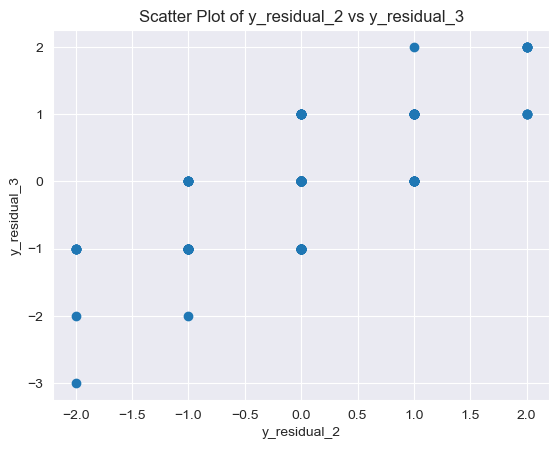

In [185]:
import matplotlib.pyplot as plt

plt.scatter(y_residual_2, y_residual_3)
plt.xlabel('y_residual_2')
plt.ylabel('y_residual_3')
plt.title('Scatter Plot of y_residual_2 vs y_residual_3')
plt.show()

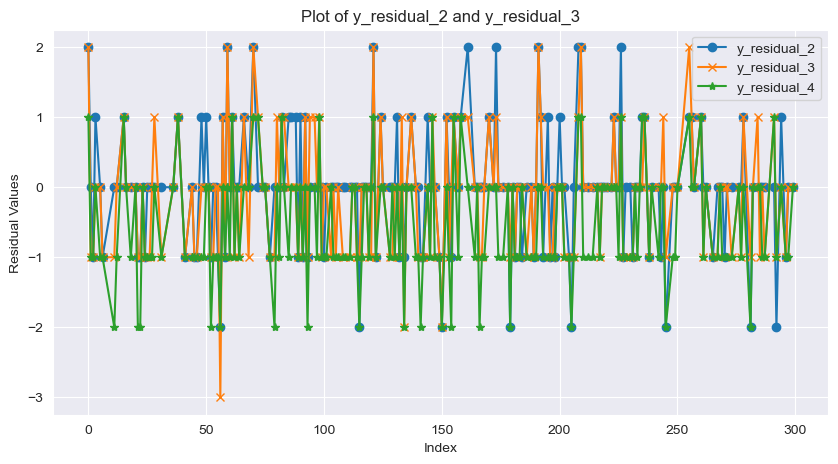

In [186]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
# plt.plot(y_residual_0, label='y_residual_0', marker='.')
plt.plot(y_residual_2, label='y_residual_2', marker='o')
plt.plot(y_residual_3, label='y_residual_3', marker='x')
plt.plot(y_residual_4, label='y_residual_4', marker='*')
plt.title('Plot of y_residual_2 and y_residual_3')
plt.xlabel('Index')
plt.ylabel('Residual Values')
plt.legend()
plt.grid(True)
plt.show()

In [162]:
import pandas as pd

# Load your three submission files
sub1 = train_Tuned
sub2 = train_Tuned_2
sub3 = train_Tuned_3

# # Ensure the IDs are aligned (if not sorted)
# sub1 = sub1.sort_values(by='id').reset_index(drop=True)
# sub2 = sub2.sort_values(by='id').reset_index(drop=True)
# sub3 = sub3.sort_values(by='id').reset_index(drop=True)

# Combine the three predictions
combined = pd.DataFrame({
    'sii_1': sub1,
    'sii_2': sub2,
    'sii_3': sub3
})

# Apply the decision logic
def resolve_vote(row):
    # Count the occurrences of each value
    counts = row.value_counts()
    # Check if any value occurs at least twice
    if counts.max() >= 2:
        # Return the most frequent value
        return counts.idxmax()
    else:
        # If all are unique, return the smallest value
        return row.min()

combined['final_sii'] = combined[['sii_1', 'sii_2', 'sii_3']].apply(resolve_vote, axis=1)



In [163]:
quadratic_weighted_kappa(y_save_0, combined['final_sii'])

0.23741445237341385

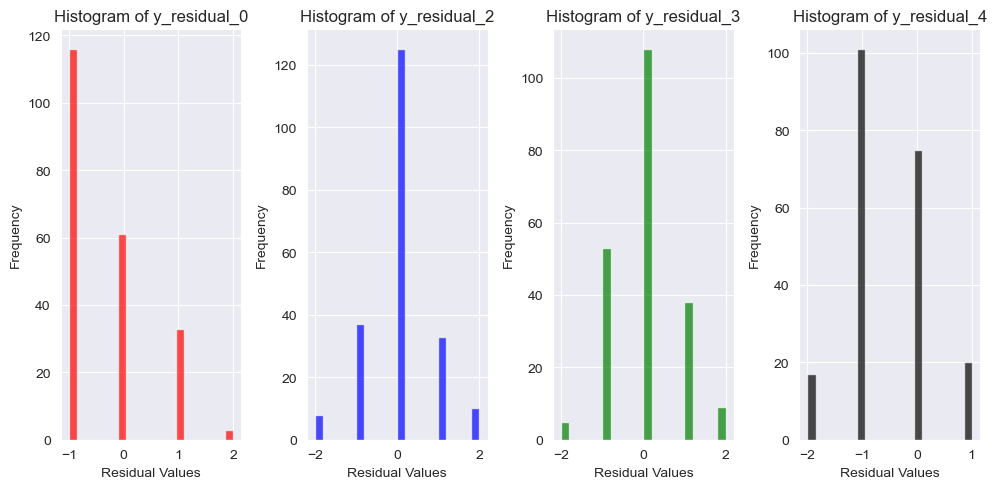

In [164]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

plt.subplot(1, 4, 1)
plt.hist(y_residual_0, bins=20, alpha=0.7, color='red')
plt.title('Histogram of y_residual_0')
plt.xlabel('Residual Values')
plt.ylabel('Frequency')

plt.subplot(1, 4, 2)
plt.hist(y_residual_2, bins=20, alpha=0.7, color='blue')
plt.title('Histogram of y_residual_2')
plt.xlabel('Residual Values')
plt.ylabel('Frequency')

plt.subplot(1, 4, 3)
plt.hist(y_residual_3, bins=20, alpha=0.7, color='green')
plt.title('Histogram of y_residual_3')
plt.xlabel('Residual Values')
plt.ylabel('Frequency')

plt.subplot(1, 4, 4)
plt.hist(y_residual_4, bins=20, alpha=0.7, color='black')
plt.title('Histogram of y_residual_4')
plt.xlabel('Residual Values')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [216]:
y_save_2[:10]

0     2.0
1     0.0
2     0.0
3     1.0
5     1.0
6     0.0
11    0.0
12    1.0
15    2.0
16    0.0
Name: sii, dtype: float64

In [217]:
sample

,id,sii
0,00008ff9,0
1,000fd460,0
2,00105258,1
3,00115b9f,0
4,0016bb22,0
5,001f3379,0
6,0038ba98,1
7,0068a485,0
8,0069fbed,2
9,0083e397,0


In [259]:
import pandas as pd

# Load your three submission files
sub1 = Submission
sub2 = Submission1
sub3 = sample

# Ensure the IDs are aligned (if not sorted)
sub1 = sub1.sort_values(by='id').reset_index(drop=True)
sub2 = sub2.sort_values(by='id').reset_index(drop=True)
sub3 = sub3.sort_values(by='id').reset_index(drop=True)

# Combine the three predictions
combined = pd.DataFrame({
    'id': sub1['id'],
    'sii_1': sub1['sii'],
    'sii_2': sub2['sii'],
    'sii_3': sub3['sii']
})

# Apply majority voting
def majority_vote(row):
    return row.mode()[0]  # Mode gets the most frequent value (majority vote)

combined['sii_mean'] = combined[['sii_1', 'sii_2', 'sii_3']].mean(axis=1)
combined['sii_mean'] = combined['sii_mean'].round(0).astype(int)

# Create the final submission DataFrame
final_submission = combined[['id', 'sii_mean']].rename(columns={'sii_mean': 'sii'})

# Save the final submission to a CSV file
final_submission.to_csv('submission.csv', index=False)

print("Majority voting completed and saved to 'Final_Submission.csv'")

Majority voting completed and saved to 'Final_Submission.csv'


In [260]:
final_submission

,id,sii
0,00008ff9,0
1,000fd460,0
2,00105258,1
3,00115b9f,0
4,0016bb22,0
5,001f3379,1
6,0038ba98,1
7,0068a485,0
8,0069fbed,2
9,0083e397,0


In [219]:
# # Load your three submission files
# sub1 = Submission
# sub2 = Submission1
# sub3 = sample

# sub1 = sub1.sort_values(by='id').reset_index(drop=True)
# sub2 = sub2.sort_values(by='id').reset_index(drop=True)
# sub3 = sub3.sort_values(by='id').reset_index(drop=True)

# sub1 = sub1.rename(columns={'sii': 'sii_1'})
# sub2 = sub2.rename(columns={'sii': 'sii_2'})
# sub3 = sub3.rename(columns={'sii': 'sii_3'})
# subs = pd.merge(sub1,sub2,on=['id'])
# subs = pd.merge(subs,sub3,on=['id'])

# #subs['sii_s'] = subs['sii_1'] *0.555 + 0.001* subs['sii_2'] + 0.444* subs['sii_3']
# #subs['sii_s'] = subs['sii_1'] *0.450 + 0.450* subs['sii_2'] + 0.100* subs['sii_3']
# #subs['sii_s'] = subs['sii_1'] *0.525 + 0.050* subs['sii_2'] + 0.425* subs['sii_3']
# #subs['sii_s'] = subs['sii_1'] *0.500 + 0.100* subs['sii_2'] + 0.400* subs['sii_3']

# subs['sii_s'] = np.round(subs['sii_1'] *0.85 + 0.10* subs['sii_2'] + 0.05* subs['sii_3'])

# subs['sii_s'] = subs['sii_s'].astype(int)

# combined = pd.DataFrame({
    
#     'id'   : sub1['id'],
    
#     'sii_1': sub1['sii_1'],
#     'sii_2': sub2['sii_2'],
#     'sii_3': sub3['sii_3'],
    
#     'sii_s': subs['sii_s'],
# })

# display(combined)

# def majority_vote(row):
#     return row.mode()[0]
                                                         
# combined['final_sii'] = combined[['sii_1', 'sii_2', 'sii_3', 'sii_s']].apply(majority_vote, axis=1)

# final_submission = combined[['id', 'final_sii']].rename(columns={'final_sii': 'sii'})

# final_submission.to_csv('submission.csv', index=False)

# print("Majority voting completed and saved to 'Final_Submission.csv'")

In [220]:
# X = train.drop(['sii'], axis=1)
# y = train['sii']

In [221]:
# X_train=X
# y_train=y

In [222]:
# from sklearn.model_selection import RandomizedSearchCV
# from sklearn.impute import SimpleImputer
# from sklearn.pipeline import Pipeline
# from sklearn.ensemble import VotingRegressor
# from lightgbm import LGBMRegressor
# from xgboost import XGBRegressor
# from catboost import CatBoostRegressor
# from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# # Define hyperparameter grids for each model

# # LightGBM hyperparameter grid
# lgb_param_grid = {
#     'regressor__learning_rate': [0.01, 0.03, 0.046, 0.1],
#     'regressor__max_depth': [8, 12, 16],
#     'regressor__num_leaves': [128, 256, 478, 512],
#     'regressor__min_data_in_leaf': [10, 13, 16],
#     'regressor__feature_fraction': [0.7, 0.8, 0.893],
#     'regressor__bagging_fraction': [0.7, 0.784, 0.85],
#     'regressor__lambda_l1': [5, 10, 15],
#     'regressor__lambda_l2': [0.001, 0.01, 0.1]
# }

# # XGBoost hyperparameter grid
# xgb_param_grid = {
#     'regressor__learning_rate': [0.01, 0.05, 0.1],
#     'regressor__max_depth': [4, 6, 8],
#     'regressor__n_estimators': [100, 200, 300],
#     'regressor__subsample': [0.7, 0.8, 0.9],
#     'regressor__colsample_bytree': [0.7, 0.8, 0.9],
#     'regressor__reg_alpha': [0.1, 1, 5],
#     'regressor__reg_lambda': [1, 5, 10]
# }

# # CatBoost hyperparameter grid
# cat_param_grid = {
#     'regressor__learning_rate': [0.03, 0.05, 0.07],
#     'regressor__depth': [4, 6, 8],
#     'regressor__iterations': [200, 300, 400],
#     'regressor__l2_leaf_reg': [3, 10, 15]
# }

# # RandomForest hyperparameter grid
# rf_param_grid = {
#     'regressor__n_estimators': [100, 200, 300],
#     'regressor__max_depth': [10, 20, 30],
#     'regressor__min_samples_split': [2, 5, 10],
#     'regressor__min_samples_leaf': [1, 2, 4]
# }

# # GradientBoosting hyperparameter grid
# gb_param_grid = {
#     'regressor__learning_rate': [0.01, 0.05, 0.1],
#     'regressor__n_estimators': [100, 200, 300],
#     'regressor__max_depth': [3, 5, 7],
#     'regressor__subsample': [0.7, 0.8, 0.9]
# }

# # Imputer for handling missing values
# imputer = SimpleImputer(strategy='median')

# # Pipelines for each regressor
# lgb_pipeline = Pipeline(steps=[('imputer', imputer), ('regressor', LGBMRegressor(random_state=SEED))])
# xgb_pipeline = Pipeline(steps=[('imputer', imputer), ('regressor', XGBRegressor(random_state=SEED))])
# cat_pipeline = Pipeline(steps=[('imputer', imputer), ('regressor', CatBoostRegressor(random_state=SEED, silent=True))])
# rf_pipeline = Pipeline(steps=[('imputer', imputer), ('regressor', RandomForestRegressor(random_state=SEED))])
# gb_pipeline = Pipeline(steps=[('imputer', imputer), ('regressor', GradientBoostingRegressor(random_state=SEED))])

# # Perform RandomizedSearchCV for each model

# # LightGBM
# lgb_search = RandomizedSearchCV(lgb_pipeline, lgb_param_grid, n_iter=20, scoring='neg_mean_squared_error', cv=3, random_state=SEED)
# lgb_search.fit(X_train, y_train)

# # XGBoost
# xgb_search = RandomizedSearchCV(xgb_pipeline, xgb_param_grid, n_iter=20, scoring='neg_mean_squared_error', cv=3, random_state=SEED)
# xgb_search.fit(X_train, y_train)

# # CatBoost
# cat_search = RandomizedSearchCV(cat_pipeline, cat_param_grid, n_iter=20, scoring='neg_mean_squared_error', cv=3, random_state=SEED)
# cat_search.fit(X_train, y_train)

# # RandomForest
# rf_search = RandomizedSearchCV(rf_pipeline, rf_param_grid, n_iter=20, scoring='neg_mean_squared_error', cv=3, random_state=SEED)
# rf_search.fit(X_train, y_train)

# # GradientBoosting
# gb_search = RandomizedSearchCV(gb_pipeline, gb_param_grid, n_iter=20, scoring='neg_mean_squared_error', cv=3, random_state=SEED)
# gb_search.fit(X_train, y_train)

# # Get the best models from the RandomizedSearchCV results
# best_lgb = lgb_search.best_estimator_
# best_xgb = xgb_search.best_estimator_
# best_cat = cat_search.best_estimator_
# best_rf = rf_search.best_estimator_
# best_gb = gb_search.best_estimator_

# # Create a new ensemble with the best estimators
# ensemble = VotingRegressor(estimators=[
#     ('lgb', best_lgb),
#     ('xgb', best_xgb),
#     ('cat', best_cat),
#     ('rf', best_rf),
#     ('gb', best_gb)
# ])

# # Train the ensemble
# predictions = TrainML(ensemble, test)

# # Save predictions to a CSV file
# sample['sii'] = predictions
# sample.to_csv('submission.csv', index=False)

In [225]:
quadratic_weighted_kappa(y_save_0, train_Tuned)

0.06156868247509484

In [226]:
quadratic_weighted_kappa(y_save_2, train_Tuned_2)

0.4240467855870207

In [227]:
quadratic_weighted_kappa(y_save_3, train_Tuned_3)

0.4205708363918994

In [231]:
y_save_3

0      2.0
1      0.0
2      0.0
3      1.0
5      1.0
      ... 
292    0.0
294    1.0
296    0.0
297    0.0
299    1.0
Name: sii, Length: 213, dtype: float64